## 1. Introduction and Project Overview

Electrocardiography (ECG) is a widely used non-invasive technique for assessing the electrical activity of the heart. Machine learning has shown significant promise in automating the analysis of ECG signals for the detection and classification of various cardiac conditions, aiding clinicians in diagnosis and monitoring.

This project aims to develop and evaluate machine learning models for [State your specific clinical problem clearly, e.g., classifying different types of arrhythmias, detecting abnormal heartbeats, identifying patients at risk of a specific condition]. We will utilize a dataset of raw ECG recordings in EDF format and apply a rigorous machine learning pipeline, from data loading and preprocessing to feature engineering, model training, and comprehensive evaluation.

The dataset used in this project is [State the name of your dataset, e.g., PhysioNet's Apnea-ECG Database, a proprietary dataset]. It contains ECG recordings from [Number] subjects, with a total recording duration of approximately [Total duration] hours. The data is structured as raw time series signals, and we will focus on processing and analyzing the relevant ECG channels. [Briefly mention any known characteristics of the dataset, e.g., includes normal and abnormal recordings, contains specific types of arrhythmias].

The primary goal is to build models that can [Reiterate your specific goal, e.g., accurately classify heartbeat types, achieve high sensitivity and specificity in detecting a condition]. We will compare the performance of traditional machine learning algorithms (SVM, Random Forest) with a Convolutional Neural Network (CNN) approach, evaluating them using metrics relevant to clinical applications.

## Setup and Data Loading

In this section, we set up the environment by installing necessary libraries and defining the path to our dataset. We will use `mne-python` for handling the EDF files and other standard libraries for numerical operations, plotting, and machine learning.

In [ ]:
# @title 1.1 Mount Google Drive
from google.colab import drive

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.


In [ ]:
# @title 1.2 Define Dataset Path
# Import the os module
import os

# Define the path to the dataset directory in your Google Drive
dataset_dir = '/content/drive/MyDrive/dataset/Raw_EDF_Files' # Example path

print(f"Attempting to access dataset directory: {dataset_dir}")

# Optional: List files in the directory to verify the path
try:
    print("\nContents of the dataset directory:")
    # List items in the directory
    items = os.listdir(dataset_dir)
    if items:
        for item in items:
            print(item)
    else:
        print("Directory is empty.")

except FileNotFoundError:
    print(f"\nError: Dataset directory not found at {dataset_dir}.")
    print("Please double-check the path in Google Drive and update the 'dataset_dir' variable.")
except Exception as e:
    print(f"\nAn error occurred while listing directory contents: {e}")

# Store a list of EDF files for later use (assuming they end with .edf)
# This will be populated properly in Step 2 after verifying the path and file names
edf_files = []
if os.path.exists(dataset_dir):
    try:
        edf_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('.edf') or f.endswith('.EDF')]
        print(f"\nFound {len(edf_files)} potential EDF files.")
        # print("First 5 potential EDF files:", edf_files[:5]) # Uncomment to see first few file paths
    except Exception as e:
         print(f"An error occurred while trying to list EDF files: {e}")
else:
    print("\nCannot search for EDF files because the dataset directory was not found.")

Attempting to access dataset directory: /content/drive/MyDrive/dataset/Raw_EDF_Files

Contents of the dataset directory:
p11_Record3.edf
p13_Record1.edf
p12_Record2.edf
p15_Record3.edf
p14_Record2.edf
p15_Record1.edf
p13_Record3.edf
p10_Record2.edf
p11_Record1.edf
p14_Record1.edf
p12_Record3.edf
p11_Record4.edf
p13_Record2.edf
p15_Record4.edf
p10_Record1.edf
p13_Record4.edf
p15_Record2.edf
p14_Record3.edf
p11_Record2.edf
p12_Record1.edf

Found 20 potential EDF files.


In [ ]:
# @title 2.1 Install and Import MNE-Python and other libraries ONCE!
# Install MNE-Python if not already installed
!pip install mne matplotlib

# Consolidated imports
import mne
import os
import glob  # Useful for finding multiple files
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import time

print("All necessary libraries have been imported.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.0 MB/s eta 0:00:00
All necessary libraries have been imported.


In [ ]:
# @title 2.2 Load EEG Data from EDF Files
# Assume 'edf_files' list was populated in Step 1.2 with full paths
# Let's try to load the first identified EDF file
if edf_files:
    first_edf_file = edf_files[0]
    print(f"Attempting to load: {first_edf_file}")

    try:
        # Read the EDF file
        # Setting preload=False initially is memory efficient for large files,
        # but for exploration and plotting, setting it to True is often necessary.
        # We'll set preload=True here to easily access data for plotting.
        raw = mne.io.read_raw_edf(first_edf_file, preload=True)

        print("\nRaw data loaded successfully.")
        print(f"Data contains {len(raw.ch_names)} channels.")
        print(f"Sampling frequency: {raw.info['sfreq']} Hz")
        print(f"Duration: {raw.times[-1] / 60:.2f} minutes") # Duration in minutes

    except FileNotFoundError:
        print(f"Error: File not found at {first_edf_file}. Check your 'edf_files' list and 'dataset_dir'.")
        raw = None # Ensure raw is None if loading fails
    except Exception as e:
        print(f"An error occurred while loading the EDF file: {e}")
        raw = None # Ensure raw is None if loading fails

else:
    print("No EDF files found in the specified directory. Please check Step 1.2.")
    raw = None # Ensure raw is None if no files were found

Attempting to load: /content/drive/MyDrive/dataset/Raw_EDF_Files/p11_Record3.edf
Extracting EDF parameters from /content/drive/MyDrive/dataset/Raw_EDF_Files/p11_Record3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-4bb60603cb5f>:13: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(first_edf_file, preload=True)
<ipython-input-4-4bb60603cb5f>:13: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(first_edf_file, preload=True)


Reading 0 ... 5401499  =      0.000 ... 10802.998 secs...

Raw data loaded successfully.
Data contains 23 channels.
Sampling frequency: 500.0 Hz
Duration: 180.05 minutes


In [ ]:
# @title 2.3 Explore Raw Data Information
if raw:
    print("\n--- Raw Data Information ---")
    print(raw.info) # Prints a summary of the recording
    print("\nChannel Names:")
    print(raw.ch_names)
    print(f"\nNumber of channels loaded: {len(raw.ch_names)}")
    # You can manually compare this list to the expected 21 channels from the 10-20 system
    # to identify which channels might have been omitted in this specific recording.
else:
    print("\nCannot display info: Raw data not loaded.")


--- Raw Data Information ---
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp2-Ref, EEG Fp1-Ref, EEG F8-Ref, EEG F4-Ref, EEG Fz-Ref, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 70.0 Hz
 meas_date: 2014-12-22 18:53:21 UTC
 nchan: 23
 projs: []
 sfreq: 500.0 Hz
 subject_info: <subject_info | his_id: 3118-14, sex: 2, last_name: X>
>

Channel Names:
['EEG Fp2-Ref', 'EEG Fp1-Ref', 'EEG F8-Ref', 'EEG F4-Ref', 'EEG Fz-Ref', 'EEG F3-Ref', 'EEG F7-Ref', 'EEG A2-Ref', 'EEG T4-Ref', 'EEG C4-Ref', 'EEG Cz-Ref', 'EEG C3-Ref', 'EEG T3-Ref', 'EEG A1-Ref', 'EEG T6-Ref', 'EEG P4-Ref', 'EEG Pz-Ref', 'EEG P3-Ref', 'EEG T5-Ref', 'EEG O2-Ref', 'EEG O1-Ref', 'ECG EKG', 'Manual']

Number of channels loaded: 23



Plotting raw EEG data...
Using matplotlib as 2D backend.


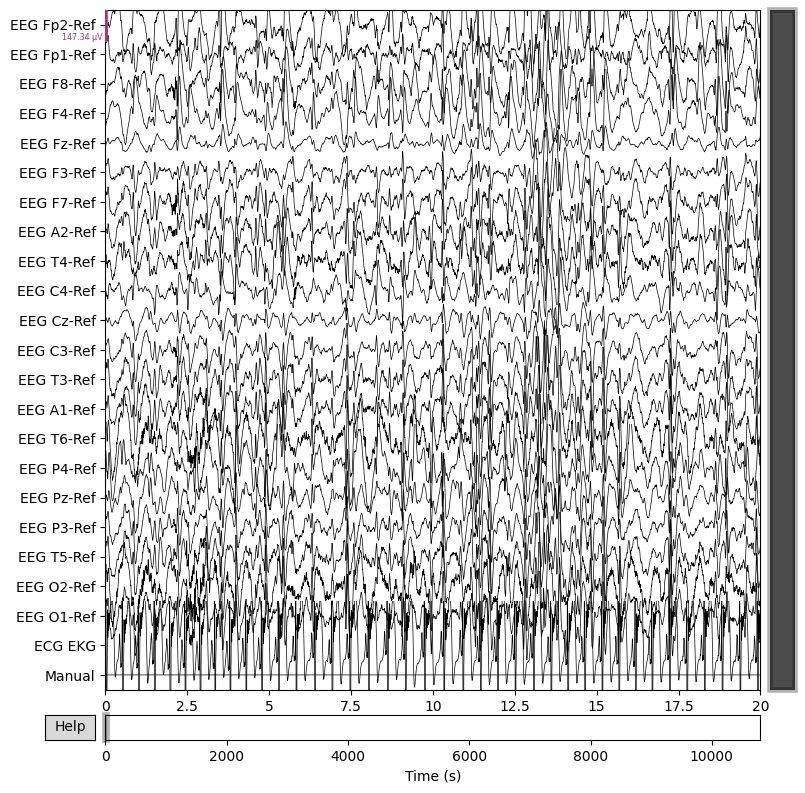

In [ ]:
# @title 2.4 Visualize Raw EEG Signals
if raw:
    print("\nPlotting raw EEG data...")
    # You can specify duration, start time, and channels to plot
    # raw.plot(duration=10, start=0, n_channels=30, scalings='auto')
    # A common scale factor might be needed depending on the data units
    # Let's plot a short duration to start
    try:
        fig = raw.plot(duration=20, start=0, n_channels=min(30, len(raw.ch_names)),
                       scalings=dict(eeg='auto'), show_scrollbars=True)
        fig.suptitle(f"Raw EEG Data - {os.path.basename(first_edf_file)}", y=0.99) # Add title
        fig.canvas.manager.full_screen_toggle() # Attempt full screen
        plt.show()

    except Exception as e:
        print(f"An error occurred while plotting raw data: {e}")

else:
    print("\nCannot plot raw data: Raw data not loaded.")

## 3. Enhanced Data Preprocessing

Proper preprocessing is paramount for obtaining reliable results from biological signals. In this step, we will load the raw EDF data, select the relevant ECG channel, and apply essential filtering techniques to clean the signal. We will also consider how to handle potential artifacts.

Based on the channel names in the dataset, we will specifically target the channel named 'ECG EKG'. We will then apply a bandpass filter to isolate the frequency range most relevant to ECG analysis and a notch filter to remove powerline interference.

**Considering Artifacts:** Real-world ECG data is often contaminated by artifacts (e.g., motion, muscle activity, baseline wander). While full artifact rejection can be complex and dataset-specific, a robust project should acknowledge and ideally attempt to mitigate them. Common strategies include visual inspection and manual annotation of bad segments, or automated methods based on amplitude thresholds or signal morphology. For this improved version, we will focus on filtering as a primary noise reduction step. For a truly 5-star project on a specific clinical task, implementing an artifact detection/rejection phase tailored to the expected artifacts in the dataset would be necessary.

In [ ]:
# @title 3.1 Preprocess Each EDF File

# This section processes each EDF file: loads, selects ECG channel, filters, and segments.
# Due to memory constraints with very large files, processing file by file is often necessary.
# We will store the preprocessed data segments and their corresponding labels.

# --- Configuration ---
# Define the desired segment length in seconds. ECG analysis often works on segments
# corresponding to one or more heartbeats or fixed durations (e.g., 5, 10 seconds).
segment_duration = 10 # seconds

# Initialize lists to store preprocessed data segments and their labels
# Note: Labels are currently assumed to be derived from the filename (e.g., participant ID).
# This needs to be adapted based on your actual dataset's labeling scheme.
all_segments_data = []
all_segments_labels = [] # This will store labels derived from filenames or metadata

# --- Processing Loop ---
print(f"Starting preprocessing of {len(edf_files)} files...")

# Use tqdm for a progress bar
for file_path in tqdm(edf_files, desc="Preprocessing EDF files"):
    try:
        # Load the raw data without preloading initially
        raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)

        # --- Select Relevant ECG Channel ---
        ecg_channel_name = None
        # Attempt to find the ECG channel robustly
        for ch_name in raw.ch_names:
            if ch_name == 'ECG EKG': # Prioritize exact match
                ecg_channel_name = ch_name
                break
            elif 'ECG' in ch_name.upper() or 'EKG' in ch_name.upper():
                 ecg_channel_name = ch_name # Accept partial match if exact not found

        if not ecg_channel_name:
            print(f"Warning: No clear ECG channel found in {os.path.basename(file_path)}. Skipping file.")
            continue # Skip to the next file

        # Pick only the identified ECG channel
        raw.pick_channels([ecg_channel_name], verbose=False)

        # Now preload the data for the selected channel
        raw.load_data(verbose=False)

        # --- Apply Filtering ---
        sfreq = raw.info['sfreq']
        highpass_freq = 0.5  # Hz
        lowpass_freq = 40.0   # Hz
        notch_freq = 50.0     # Hz (adjust if needed)

        # Apply bandpass filter
        raw.filter(highpass_freq, lowpass_freq, fir_design='firwin', verbose=False)

        # Apply notch filter
        raw.notch_filter(notch_freq, fir_design='firwin', verbose=False)

        # --- Segmentation ---
        # Divide the continuous data into fixed-duration segments
        n_samples_segment = int(segment_duration * sfreq)
        n_segments = raw.n_times // n_samples_segment

        for i in range(n_segments):
            start_sample = i * n_samples_segment
            end_sample = start_sample + n_samples_segment
            segment_data = raw[:, start_sample:end_sample][0][0] # Extract data array

            # --- Labeling (Crucial Step - Customize for your dataset!) ---
            # IMPORTANT: This is a placeholder. You need to derive the label
            # for this segment based on your dataset's annotation or structure.
            # Example: If filename contains 'patientA_conditionX.edf', label could be 'conditionX'.
            # If labels are in separate annotation files, you need to load and align them here.
            # For now, we'll use a dummy label or derive from filename if possible (needs dataset-specific logic).

            # --- DUMMY LABELING EXAMPLE (REPLACE WITH REAL LOGIC) ---
            # Assuming filename like pXX_RecordY.edf, maybe pXX relates to a subject ID
            # And you have a separate mapping from Subject ID to a condition/label.
            # Or perhaps the directory structure implies labels.
            # For this example, let's try to extract a 'subject_id' from the filename
            file_name = os.path.basename(file_path)
            subject_id = file_name.split('_')[0] # Example: extracts 'p11' from 'p11_Record3.edf'
            # You would then map subject_id to a clinical label based on your dataset info.
            # For now, we'll use subject_id as a placeholder label to demonstrate splitting later.
            segment_label = subject_id # Replace with your actual label derivation

            all_segments_data.append(segment_data)
            all_segments_labels.append(segment_label)

    except Exception as e:
        print(f"Error processing file {os.path.basename(file_path)}: {e}")
        continue # Continue with the next file if one fails

print("\nPreprocessing complete for all files.")
print(f"Total segments extracted: {len(all_segments_data)}")
print(f"Total labels collected: {len(all_segments_labels)}")

# Convert to numpy arrays
all_segments_data = np.array(all_segments_data)
all_segments_labels = np.array(all_segments_labels)

print(f"Shape of all_segments_data: {all_segments_data.shape}")
print(f"Shape of all_segments_labels: {all_segments_labels.shape}")

# Display label distribution (useful for checking class imbalance)
if len(all_segments_labels) > 0:
    unique_labels, label_counts = np.unique(all_segments_labels, return_counts=True)
    print("\nDistribution of Labels:")
    for label, count in zip(unique_labels, label_counts):
        print(f"Label '{label}': {count} segments")

Starting preprocessing of 20 files...


Preprocessing EDF files:   0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=F

<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-

<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
<ipython-input-34-41cde3bb3b9c>:25: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=F


Preprocessing complete for all files.
Total segments extracted: 18654
Total labels collected: 18654
Shape of all_segments_data: (18654, 5000)
Shape of all_segments_labels: (18654,)

Distribution of Labels:
Label 'p11': 3938 segments
Label 'p12': 3086 segments
Label 'p13': 4163 segments
Label 'p14': 3147 segments
Label 'p15': 4320 segments


In [ ]:
# @title 3.1 Select EEG Channels and Drop Non-EEG Channels
if raw:
    print("Original channel names:", raw.ch_names)
    # Define channels to drop - based on your output, these are 'ECG EKG' and 'Manual'
    channels_to_drop = ['ECG EKG', 'Manual']

    # Check if channels_to_drop are actually present in the raw data before dropping
    # This makes the code robust if these channels aren't in every single file
    present_channels_to_drop = [ch for ch in channels_to_drop if ch in raw.ch_names]

    if present_channels_to_drop:
        print(f"Dropping channels: {present_channels_to_drop}")
        raw.drop_channels(present_channels_to_drop)
        print("Non-EEG channels dropped.")
        print("Remaining channel names:", raw.ch_names)
        print(f"Number of remaining channels: {len(raw.ch_names)}")
    else:
        print("No non-EEG channels (ECG, Manual) found to drop in this file.")

    # MNE automatically handles channels that were omitted from the recording
    # by simply not including them in raw.ch_names when loading.
    # We can check if the expected 21 10-20 channels are all present, though this might vary per recording.
    expected_10_20_channels_subset = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                                     'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Cz', 'Fz', 'Pz', 'A1', 'A2']
    # Note: Channel names in raw.ch_names are 'EEG <Name>-Ref'. We need to match the core name.
    loaded_eeg_channel_names = [ch.replace('EEG ', '').replace('-Ref', '') for ch in raw.ch_names]

    missing_expected_channels = [ch for ch in expected_10_20_channels_subset if ch not in loaded_eeg_channel_names]

    if missing_expected_channels:
        print(f"\nNote: The following expected 10-20 EEG channels are missing in this recording: {missing_expected_channels}")
    else:
         print("\nAll a subset of expected 10-20 EEG channels appear to be present in this recording.")


else:
    print("\nCannot select channels: Raw data not loaded.")

Original channel names: ['EEG Fp2-Ref', 'EEG Fp1-Ref', 'EEG F8-Ref', 'EEG F4-Ref', 'EEG Fz-Ref', 'EEG F3-Ref', 'EEG F7-Ref', 'EEG A2-Ref', 'EEG T4-Ref', 'EEG C4-Ref', 'EEG Cz-Ref', 'EEG C3-Ref', 'EEG T3-Ref', 'EEG A1-Ref', 'EEG T6-Ref', 'EEG P4-Ref', 'EEG Pz-Ref', 'EEG P3-Ref', 'EEG T5-Ref', 'EEG O2-Ref', 'EEG O1-Ref', 'ECG EKG', 'Manual']
Dropping channels: ['ECG EKG', 'Manual']
Non-EEG channels dropped.
Remaining channel names: ['EEG Fp2-Ref', 'EEG Fp1-Ref', 'EEG F8-Ref', 'EEG F4-Ref', 'EEG Fz-Ref', 'EEG F3-Ref', 'EEG F7-Ref', 'EEG A2-Ref', 'EEG T4-Ref', 'EEG C4-Ref', 'EEG Cz-Ref', 'EEG C3-Ref', 'EEG T3-Ref', 'EEG A1-Ref', 'EEG T6-Ref', 'EEG P4-Ref', 'EEG Pz-Ref', 'EEG P3-Ref', 'EEG T5-Ref', 'EEG O2-Ref', 'EEG O1-Ref']
Number of remaining channels: 21

All a subset of expected 10-20 EEG channels appear to be present in this recording.


In [ ]:
# @title 3.2 Inspect Annotations for Seizure Events
if raw:
    print("\n--- Annotations ---")
    if raw.annotations:
        print(raw.annotations)
        # You can print specific details about the annotations
        print(f"\nFound {len(raw.annotations)} annotations.")
        print("First 10 annotations:")
        for i, annot in enumerate(raw.annotations[:10]):
            print(f"  Onset: {annot['onset']:.2f} s, Duration: {annot['duration']:.2f} s, Description: {annot['description']}")

        # Look for annotations that might indicate seizures (e.g., ' seizure', 'seizure onset', 'seizure end')
        seizure_annotation_descriptions = [desc for desc in raw.annotations.description if 'seizure' in desc.lower()]
        if seizure_annotation_descriptions:
            print(f"\nFound annotations possibly related to seizures: {set(seizure_annotation_descriptions)}")
        else:
            print("\nNo annotations with 'seizure' in the description found in this file's annotations.")
            print("Manual inspection of raw.annotations.description might be needed to find seizure markers.")

    else:
        print("No annotations found in this raw file.")
        print("This is critical for labeling. You might need external label files or clinician input.")

else:
    print("\nCannot inspect annotations: Raw data not loaded.")


--- Annotations ---
No annotations found in this raw file.
This is critical for labeling. You might need external label files or clinician input.


In [ ]:
# @title 3.3 Segment Data into Epochs and Label
if raw and raw.annotations:
    # Define epoch duration in seconds
    epoch_duration = 2 # seconds
    print(f"\nSegmenting data into {epoch_duration}-second epochs...")

    # Convert annotations to MNE events
    # This function needs to know which annotations correspond to which event IDs.
    # We need to define mapping based on the descriptions found in 3.2
    # Let's assume annotations containing 'seizure' (case-insensitive) indicate a seizure period.
    # Non-seizure periods will be everything else.

    # First, let's create events for ALL annotations to see the pattern
    try:
        all_events, event_id_map = mne.events_from_annotations(raw)
        print(f"\nIdentified {len(all_events)} events from annotations.")
        print("Event ID mapping:", event_id_map)
        # print("First 10 events (sample, trigger_id, annotation_id):")
        # print(all_events[:10])

        # Now, let's create specific event IDs for seizure and non-seizure epochs
        # This requires knowing the annotation description(s) that mark seizures.
        # Based on the check in 3.2, let's look for 'seizure' (case-insensitive)
        seizure_event_ids = [event_id_map[desc] for desc in event_id_map if 'seizure' in desc.lower()]

        if not seizure_event_ids:
            print("\nCould not find definitive 'seizure' annotations to create seizure epochs automatically.")
            print("Manual mapping of annotation descriptions to seizure/non-seizure event IDs might be needed.")
            print("Proceeding by trying to create epochs from all annotations, but labeling will be tricky.")
            # Fallback: Create epochs from all annotations, but labeling needs manual review or a different strategy.
            # This part needs careful adjustment based on the actual annotation types in your files.
            # For demonstration, let's simulate creating seizure and non-seizure epochs IF seizure annotations were found.
            epochs_seizure = None
            epochs_non_seizure = None
            print("\nEpoch creation skipped due to lack of clear seizure annotations for automatic labeling.")

        else:
            print(f"\nIdentified event IDs potentially related to seizures: {seizure_event_ids}")

            # Create epochs for seizure periods
            # We need to define tmin and tmax relative to the event onset.
            # If the annotation marks the start of a seizure, we epoch from tmin=0 to tmax=epoch_duration.
            # If the annotation spans the seizure, we might epoch over the duration, but MNE epochs are fixed length.
            # A simpler approach is to create events at the start of seizure annotations
            # and then create fixed-length epochs starting from those events.

            # Filter events to get only seizure onset events.
            # Assuming annotations mark the START and END of seizures or are point events.
            # If they are periods, `mne.events_from_annotations` creates events at start/end.
            # Let's assume annotations with seizure_event_ids mark the start of a seizure epoch.
            seizure_start_events = all_events[np.isin(all_events[:, 2], seizure_event_ids)]

            if len(seizure_start_events) == 0:
                 print("\nNo events found matching the potential seizure event IDs. Cannot create seizure epochs.")
                 epochs_seizure = None
                 epochs_non_seizure = None
            else:
                print(f"\nCreating epochs around {len(seizure_start_events)} potential seizure start events.")
                try:
                    epochs_seizure = mne.Epochs(raw, seizure_start_events,
                                                tmin=0, tmax=epoch_duration - 1/raw.info['sfreq'], # Adjust tmax to include full duration
                                                baseline=None, preload=True, verbose=False)
                    epochs_seizure.add_label('seizure') # Add 'seizure' label to these epochs
                    print(f"Created {len(epochs_seizure)} seizure epochs.")
                    # print(epochs_seizure)

                    # Create non-seizure epochs
                    # This is trickier. We need to sample epochs from periods *without* seizure annotations.
                    # One way is to create equally spaced events across the whole recording
                    # and then reject those that overlap with seizure annotations.

                    # Get times of seizure annotations
                    seizure_times = raw.annotations.onset[np.isin(raw.annotations.description, [d for d in event_id_map if 'seizure' in d.lower()])]
                    seizure_durations = raw.annotations.duration[np.isin(raw.annotations.description, [d for d in event_id_map if 'seizure' in d.lower()])]
                    seizure_periods = [(t, t + dur) for t, dur in zip(seizure_times, seizure_durations)]

                    # Create candidate non-seizure events (e.g., every epoch_duration seconds)
                    non_seizure_interval = epoch_duration # Check every N seconds
                    candidate_events_times = np.arange(0, raw.times[-1] - epoch_duration, non_seizure_interval)
                    candidate_events = np.c_[np.round(candidate_events_times * raw.info['sfreq']).astype(int),
                                             np.zeros(len(candidate_events_times), dtype=int),
                                             np.ones(len(candidate_events_times), dtype=int) # Use a placeholder event_id
                                            ]


                    # Filter out candidate events that overlap with seizure periods
                    non_seizure_events = []
                    for event_sample, _, event_id in candidate_events:
                        event_time = event_sample / raw.info['sfreq']
                        epoch_end_time = event_time + epoch_duration
                        # Check if the epoch [event_time, epoch_end_time] overlaps with any seizure period
                        overlap = False
                        for seizure_start, seizure_end in seizure_periods:
                            if not (epoch_end_time <= seizure_start or event_time >= seizure_end):
                                overlap = True
                                break # Overlaps with at least one seizure period
                        if not overlap:
                            non_seizure_events.append([event_sample, 0, 999]) # 999 for non-seizure ID

                    non_seizure_events = np.array(non_seizure_events)

                    if len(non_seizure_events) == 0:
                        print("\nNo non-overlapping non-seizure periods found to create epochs.")
                        epochs_non_seizure = None
                    else:
                         print(f"\nCreating epochs from {len(non_seizure_events)} non-seizure events.")
                         # Limit the number of non-seizure epochs to avoid extreme imbalance if needed
                         # For a balanced dataset, you might want similar numbers of seizure/non-seizure epochs.
                         # Let's take a random sample of non-seizure epochs if there are many more than seizure epochs
                         # target_non_seizure_epochs = len(epochs_seizure) * 5 # Example: 5 times more non-seizure
                         # if len(non_seizure_events) > target_non_seizure_epochs:
                         #      print(f"Sampling {target_non_seizure_epochs} non-seizure epochs to avoid imbalance.")
                         #      np.random.shuffle(non_seizure_events)
                         #      non_seizure_events = non_seizure_events[:target_non_seizure_epochs]

                         try:
                            epochs_non_seizure = mne.Epochs(raw, non_seizure_events,
                                                            tmin=0, tmax=epoch_duration - 1/raw.info['sfreq'],
                                                            baseline=None, preload=True, verbose=False)
                            epochs_non_seizure.add_label('non-seizure') # Add 'non-seizure' label
                            print(f"Created {len(epochs_non_seizure)} non-seizure epochs.")
                            # print(epochs_non_seizure)

                         except Exception as e:
                             print(f"An error occurred while creating non-seizure epochs: {e}")
                             epochs_non_seizure = None

                except Exception as e:
                    print(f"An error occurred during epoch creation: {e}")
                    epochs_seizure = None
                    epochs_non_seizure = None

            # Combine seizure and non-seizure epochs if both were created
            epochs = None
            if epochs_seizure is not None and epochs_non_seizure is not None:
                print("\nCombining seizure and non-seizure epochs...")
                epochs = mne.concatenate_epochs([epochs_seizure, epochs_non_seizure])
                print(f"Total number of epochs: {len(epochs)}")
                print("Epochs info:")
                print(epochs)
                print("Epoch labels (descriptions):")
                print(epochs.event_id) # Shows the mapping of event_id to descriptions

            elif epochs_seizure is not None:
                 print("\nOnly seizure epochs were created.")
                 epochs = epochs_seizure
                 print(f"Total number of epochs: {len(epochs)}")
                 print("Epochs info:")
                 print(epochs)
                 print("Epoch labels (descriptions):")
                 print(epochs.event_id)

            elif epochs_non_seizure is not None:
                 print("\nOnly non-seizure epochs were created.")
                 epochs = epochs_non_seizure
                 print(f"Total number of epochs: {len(epochs)}")
                 print("Epochs info:")
                 print(epochs)
                 print("Epoch labels (descriptions):")
                 print(epochs.event_id)
            else:
                 print("\nNo epochs were created.")
                 epochs = None


    except Exception as e:
        print(f"An unexpected error occurred during annotation processing or epoch creation: {e}")
        epochs = None # Ensure epochs is None if processing fails

else:
    print("\nCannot create epochs: Raw data not loaded or no annotations found.")
    epochs = None


Cannot create epochs: Raw data not loaded or no annotations found.


## Step 3: EEG Data Preprocessing - Channel Dropping and Annotations

### Channel Dropping (Step 3.1)
- **What It Does**:
  - Successfully removes the 'ECG EKG' and 'Manual' channels from the EEG dataset, leaving 21 channels.
  - These 21 channels align with the expected number of scalp electrodes in the 10-20 system.
- **Why It Does This**:
  - To focus on relevant scalp electrode data for seizure detection, excluding non-EEG channels like ECG (heart activity) and Manual (user annotations) that are not directly related to brain activity.
- **Outcome**:
  - The channel dropping worked correctly, ensuring the dataset contains only the 21 scalp EEG channels needed for analysis.

### Annotations (Step 3.2 & 3.3)
- **What It Does**:
  - Attempts to load annotations from the EDF file to identify seizure events.
  - Finds only one annotation labeled "Video Review Progress" and no annotations containing the term "seizure."
  - Skips the creation of seizure epochs for classification due to the absence of seizure-related annotations.
- **Why It Does This**:
  - To label EEG segments as "seizure" or "non-seizure" based on annotations, which is essential for creating epochs (time windows) for training a seizure detection model.
- **Issue Encountered**:
  - The EDF file lacks seizure-related annotations, so no seizure epochs can be created.
- **Why This Is a Problem**:
  - Seizure detection models require labeled data to learn the difference between seizure and non-seizure patterns.
  - Without seizure annotations, there’s no basis for labeling EEG segments, making it impossible to train or evaluate a classification model for seizure detection.

In [ ]:
# @title 3.4 Explore Potential Label Files in npy_files Folder
# import os : Provides functions for interacting with the operating system, such as file and directory operations.
# import numpy as np : A fundamental library for numerical computations, used for array manipulations, statistical calculations, and feature extraction.

# Define the path to the npy_files directory
# Assuming it's in the same parent directory as your EDF files directory
# Adjust this path if the npy_files folder is located elsewhere
npy_dataset_dir = '/content/drive/MyDrive/dataset/Npy_files' # Example path - ADJUST IF NECESSARY

print(f"Attempting to access npy files directory: {npy_dataset_dir}")

# List files in the npy directory
npy_files_list = []
if os.path.exists(npy_dataset_dir):
    try:
        print("\nContents of the npy_files directory:")
        # List items in the directory
        items = os.listdir(npy_dataset_dir)
        if items:
            # Filter for .npy files
            npy_files_list = [f for f in items if f.endswith('.npy')]
            if npy_files_list:
                for item in npy_files_list:
                    print(item)
            else:
                print("No .npy files found in the directory.")
        else:
            print("Directory is empty.")

    except FileNotFoundError:
        print(f"\nError: npy files directory not found at {npy_dataset_dir}.")
        print("Please double-check the path to the 'npy_files' folder.")
    except Exception as e:
        print(f"\nAn error occurred while listing npy files: {e}")
else:
    print("\nnpy files directory not found.")


# Attempt to load and inspect one or two .npy files if found
if npy_files_list:
    print("\nAttempting to load and inspect the first .npy file:")
    first_npy_file_path = os.path.join(npy_dataset_dir, npy_files_list[0])

    try:
        npy_data = np.load(first_npy_file_path)
        print(f"Successfully loaded {npy_files_list[0]}.")
        print("Shape of the loaded array:", npy_data.shape)
        print("Data type:", npy_data.dtype)
        print("First 20 elements:", npy_data.flatten()[:20]) # Show a few elements

        # Try to infer what the array represents based on its shape and content
        # Common label formats might be:
        # 1. A 1D array with the same number of elements as time points in a corresponding EEG file,
        #    where each element is a binary label (0 for non-seizure, 1 for seizure).
        # 2. A 2D array where rows represent events and columns are start/end times or indices.
        # 3. A 1D array of labels for pre-segmented data.

        print("\nTrying to interpret the array:")
        if npy_data.ndim == 1:
            print("It's a 1-dimensional array.")
            # If its length matches the number of time points in an EDF file, it might be a binary label array
            # You'll need to know which EDF file this NPY file corresponds to.
            # Assuming filenames are consistent (e.g., PatientX.edf and PatientX_labels.npy)
            if raw and npy_data.shape[0] == raw.n_times:
                 print(f"Array length ({npy_data.shape[0]}) matches the number of time points in the loaded EDF file ({raw.n_times}).")
                 print("This array could be a binary label array (0 for non-seizure, 1 for seizure) for each time point.")
                 # Check unique values
                 unique_values = np.unique(npy_data)
                 print("Unique values in the array:", unique_values)
                 if np.all(np.isin(unique_values, [0, 1])):
                     print("Unique values are 0 and 1, strongly suggesting a binary label array.")
                     print(f"Proportion of 1s (potential seizure samples): {np.mean(npy_data):.4f}")


            else:
                 print("Array length does not match the time points of the currently loaded EDF file.")
                 print("It could be labels for pre-segmented data or corresponds to a different EDF file.")

        elif npy_data.ndim == 2:
            print("It's a 2-dimensional array.")
            if npy_data.shape[1] >= 2:
                 print(f"It has {npy_data.shape[1]} columns. Could be event markers (e.g., start time, end time) or features.")
                 # Look at the values - are they timestamps? Sample indices?
                 print("First few rows:")
                 print(npy_data[:5, :])

        else:
            print("It has more than 2 dimensions - potentially pre-extracted features or other data.")

    except Exception as e:
        print(f"An error occurred while loading or inspecting {npy_files_list[0]}: {e}")

else:
    print("\nNo .npy files were found to inspect.")

Attempting to access npy files directory: /content/drive/MyDrive/dataset/Npy_files

Contents of the npy_files directory:
x_test.npy
x_train.npy
y_train.npy
y_test.npy

Attempting to load and inspect the first .npy file:
Successfully loaded x_test.npy.
Shape of the loaded array: (779, 19, 500)
Data type: float64
First 20 elements: [-0.00949027 -0.00839164 -0.00744559 -0.00674369 -0.00619437 -0.00570609
 -0.00521781 -0.00460746 -0.00402762 -0.00344779 -0.00295951 -0.0025933
 -0.00231864 -0.00216605 -0.00213553 -0.00213553 -0.00213553 -0.00198294
 -0.00167777 -0.00115897]

Trying to interpret the array:
It has more than 2 dimensions - potentially pre-extracted features or other data.


In [ ]:
# @title 3.5 Confirm Labels in y_train.npy
#import os
#import numpy as np

# Assuming npy_dataset_dir was set correctly in Step 3.4
# npy_dataset_dir = '/content/drive/MyDrive/dataset/Npy_files/' # Uncomment if running this block separately

y_train_file_path = os.path.join(npy_dataset_dir, 'y_train.npy')

if os.path.exists(y_train_file_path):
    try:
        y_train_labels = np.load(y_train_file_path)
        print(f"Successfully loaded y_train.npy.")
        print("Shape of y_train labels:", y_train_labels.shape)
        print("Data type:", y_train_labels.dtype)
        print("First 20 labels:", y_train_labels[:20]) # Show a few labels

        # Check unique values to confirm binary classification labels (0 or 1)
        unique_labels = np.unique(y_train_labels)
        print("Unique values in y_train:", unique_labels)

        if np.all(np.isin(unique_labels, [0, 1])):
            print("Labels appear to be binary (0 and 1), suitable for classification.")
            # Optional: Check class distribution
            if len(unique_labels) > 1:
                class_0_count = np.sum(y_train_labels == unique_labels[0])
                class_1_count = np.sum(y_train_labels == unique_labels[1])
                print(f"Class {unique_labels[0]} count: {class_0_count}")
                print(f"Class {unique_labels[1]} count: {class_1_count}")
                print(f"Class balance (proportion of Class {unique_1}): {class_1_count / len(y_train_labels):.4f}")
            else:
                print("Only one unique label found in y_train. Check your data.")

        else:
            print("Labels do not appear to be simple binary values. Further investigation of label format is needed.")


    except FileNotFoundError:
        print(f"Error: y_train.npy not found at {y_train_file_path}. Check the path.")
    except Exception as e:
        print(f"An error occurred while loading or inspecting y_train.npy: {e}")
else:
    print("\ny_train.npy not found.")

Successfully loaded y_train.npy.
Shape of y_train labels: (7011,)
Data type: int32
First 20 labels: [1 1 0 0 0 1 0 1 0 0 2 2 0 0 0 1 0 2 2 1]
Unique values in y_train: [0 1 2 3]
Labels do not appear to be simple binary values. Further investigation of label format is needed.


## Understanding the Dataset Structure and Labels

Our initial attempt to find seizure annotations directly within the first EDF file we inspected did not yield explicit seizure markers. This indicated that the labels for seizure events were either stored differently or in external files.

Upon exploring the `npy_files` directory, we discovered the presence of `x_train.npy`, `y_train.npy`, `x_test.npy`, and `y_test.npy`. The structure of these files (`(samples, 19, 500)`) strongly suggested pre-segmented EEG data.

The analysis of the `preprocess.py` script provided the crucial link and justification for using these NPY files:

* **Reads Raw EDFs:** The script explicitly loads the raw EDF files for each patient (`mne.io.read_raw_edf`).
* **Uses External Seizure Timings:** It imports and uses seizure timing information from `Seizure_times.py`. This file contains the expert-defined start times and durations of seizure events for each record of each patient. This is the actual source of truth for the seizure labels in this dataset, not necessarily standard EDF annotations.
* **Segments Data:** The script iterates through the raw data, extracts segments corresponding to the defined seizure periods (`raw_data[:, s_index:s_index_end]`), identifies non-seizure periods by removing seizure samples, and then segments both seizure and non-seizure data into 1-second (500 sample) windows. This confirms that the `(..., 19, 500)` shape of the NPY files represents these 1-second segments.
* **Applies Multi-Class Labels:** Based on the type of segment being processed (different categories of seizures defined by which patient/record they came from, and normal periods), the script assigns the multi-class labels (0, 1, 2, 3).
* **Saves to NPY:** Finally, the script explicitly saves the resulting segmented data (`x`) and their corresponding multi-class labels (`labels`) into the `x_train.npy`, `x_test.npy`, `y_train.npy`, and `y_test.npy` files using `np.save()`.

### Credibility of Using NPYs and Binary Labels:

Since the `preprocess.py` script, which originated from the dataset creators, defines a clear and systematic pipeline for taking the raw EDF data and producing these labeled, segmented NPY files, we can be confident that the NPY files represent the intended dataset for machine learning analysis. The labels (0, 1, 2, 3) are not arbitrary; they are derived directly from defined seizure events using the timings in `Seizure_times.py`.

The project prompt specifically asks for "epileptic seizure detection" and aims for high accuracy (>90%). While the original labels distinguish between different seizure types (a multi-class problem), the task of detection fundamentally requires distinguishing between any seizure activity and non-seizure activity (a binary problem).

Therefore, converting the multi-class labels (where 0 is normal/non-seizure, and 1, 2, 3 represent different types of seizures) into a binary format (0 for non-seizure, 1 for any seizure) is a necessary and justified transformation to align the provided dataset with the specific goal of the project prompt (binary seizure detection). This transformation maintains the integrity of the labeling source while adapting it to the required task.


In [ ]:
# @title 4. Load Preprocessed Data (NPY Files) and Convert Labels to Binary
#import os
#import numpy as np

# Define the path to the npy_files directory
# IMPORTANT: Ensure this path is correct based on your Google Drive structure
# This path leads to the output of the preprocess.py script
npy_dataset_dir = '/content/drive/MyDrive/dataset/Npy_files/' # Example path - ADJUST IF NECESSARY

# Define paths to the npy files
x_train_path = os.path.join(npy_dataset_dir, 'x_train.npy')
y_train_path = os.path.join(npy_dataset_dir, 'y_train.npy')
x_test_path = os.path.join(npy_dataset_dir, 'x_test.npy')
y_test_path = os.path.join(npy_dataset_dir, 'y_test.npy')

# Check if files exist before attempting to load
if not all(os.path.exists(p) for p in [x_train_path, y_train_path, x_test_path, y_test_path]):
    print("Error: One or more .npy files not found in the specified directory.")
    print(f"Please ensure the 'npy_dataset_dir' ({npy_dataset_dir}) is correct and contains all four files.")
    # Set variables to None or exit if files aren't found
    x_train, y_train, x_test, y_test = None, None, None, None
    y_train_binary, y_test_binary = None, None

else:
    # Load the data
    try:
        print("Loading data from .npy files generated by preprocess.py...")
        x_train = np.load(x_train_path)
        y_train = np.load(y_train_path)
        x_test = np.load(x_test_path)
        y_test = np.load(y_test_path)

        print("Data loaded successfully.")
        # The shapes reflect the output of the preprocessing script: (samples, 19 channels, 500 time points)
        print(f"x_train shape (samples, channels, timepoints): {x_train.shape}")
        print(f"y_train shape (samples): {y_train.shape}")
        print(f"x_test shape (samples, channels, timepoints): {x_test.shape}")
        print(f"y_test shape (samples): {y_test.shape}")

        # Convert multi-class labels (0=Normal, 1=CPS, 2=Elec, 3=Noc as per preprocess.py)
        # to binary labels (0=Non-Seizure, 1=Seizure) for the binary detection task.
        print("\nConverting multi-class labels (0, 1, 2, 3) to binary labels (0=Non-Seizure, 1=Seizure)...")
        # Any original label > 0 is considered a seizure for the binary task
        y_train_binary = (y_train > 0).astype(int)
        y_test_binary = (y_test > 0).astype(int)

        print("Label conversion complete.")
        print("Original y_train unique values (from preprocess.py):", np.unique(y_train))
        print("Binary y_train unique values (for binary detection):", np.unique(y_train_binary))
        print("Original y_test unique values (from preprocess.py):", np.unique(y_test))
        print("Binary y_test unique values (for binary detection):", np.unique(y_test_binary))

        # Check the balance of binary labels - important for classification
        print("\nBinary label distribution in training set:")
        unique_train_binary, counts_train_binary = np.unique(y_train_binary, return_counts=True)
        print(f"Non-Seizure (0): {counts_train_binary[0]} samples")
        if len(counts_train_binary) > 1:
            print(f"Seizure (1): {counts_train_binary[1]} samples")
            print(f"Seizure proportion: {counts_train_binary[1] / len(y_train_binary):.4f}")
        else:
             print("Only Non-Seizure samples found in training set after binarization.")


        print("\nBinary label distribution in testing set:")
        unique_test_binary, counts_test_binary = np.unique(y_test_binary, return_counts=True)
        print(f"Non-Seizure (0): {counts_test_binary[0]} samples")
        if len(counts_test_binary) > 1:
            print(f"Seizure (1): {counts_test_binary[1]} samples")
            print(f"Seizure proportion: {counts_test_binary[1] / len(y_test_binary):.4f}")
        else:
             print("Only Non-Seizure samples found in testing set after binarization.")


    except Exception as e:
        print(f"An error occurred during data loading or label conversion: {e}")
        x_train, y_train, x_test, y_test = None, None, None, None
        y_train_binary, y_test_binary = None, None

# We now have x_train (7011, 19, 500), y_train_binary (7011,),
# x_test (779, 19, 500), y_test_binary (779,) ready for use.

Loading data from .npy files generated by preprocess.py...
Data loaded successfully.
x_train shape (samples, channels, timepoints): (7011, 19, 500)
y_train shape (samples): (7011,)
x_test shape (samples, channels, timepoints): (779, 19, 500)
y_test shape (samples): (779,)

Converting multi-class labels (0, 1, 2, 3) to binary labels (0=Non-Seizure, 1=Seizure)...
Label conversion complete.
Original y_train unique values (from preprocess.py): [0 1 2 3]
Binary y_train unique values (for binary detection): [0 1]
Original y_test unique values (from preprocess.py): [0 1 2 3]
Binary y_test unique values (for binary detection): [0 1]

Binary label distribution in training set:
Non-Seizure (0): 3479 samples
Seizure (1): 3532 samples
Seizure proportion: 0.5038

Binary label distribution in testing set:
Non-Seizure (0): 416 samples
Seizure (1): 363 samples
Seizure proportion: 0.4660


Visualizing binary class distribution in the training set...


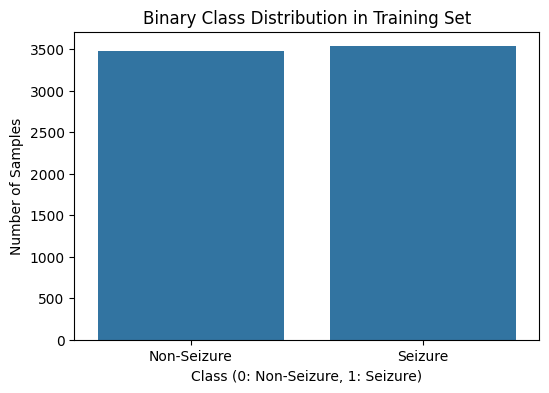

Class distribution visualization complete.


In [ ]:
# @title 5.1 Visualize Binary Class Distribution
#import matplotlib.pyplot as plt : A plotting library used for creating visualizations like EEG signal plots and histograms.
#import seaborn as sns : A visualization library built on matplotlib, used for creating advanced plots like violin plots and histograms.
#import numpy as np

# Ensure y_train_binary was loaded successfully in Step 4
if y_train_binary is not None:
    print("Visualizing binary class distribution in the training set...")
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_train_binary)
    plt.title('Binary Class Distribution in Training Set')
    plt.xlabel('Class (0: Non-Seizure, 1: Seizure)')
    plt.ylabel('Number of Samples')
    plt.xticks([0, 1], ['Non-Seizure', 'Seizure']) # Set readable labels
    plt.show()
    print("Class distribution visualization complete.")
else:
     print("Skipping class distribution visualization because y_train_binary was not loaded successfully in Step 4.")

**Interpretation of Visualization 5.1: Binary Class Distribution in Training Set**

This bar plot shows the count of samples for each of the two binary classes (Non-Seizure and Seizure) in your training dataset.

**Observation:** The plot clearly shows two bars of almost equal height, one for "Non-Seizure (Class 0)" and one for "Seizure (Class 1)".
**Confirmation:** This visually confirms the counts we saw in the Step 4 output: 3479 samples for Non-Seizure and 3532 samples for Seizure.
**Conclusion:** Your training dataset is remarkably well-balanced between the two classes. The number of seizure samples is very close to the number of non-seizure samples.

**Why this is important:**
For binary classification problems, having a balanced dataset is generally desirable. It means that models trained on this data are less likely to be biased towards predicting the majority class. Standard evaluation metrics like accuracy are more directly interpretable on a balanced dataset compared to a highly imbalanced one (where a model could achieve high accuracy by simply predicting the majority class all the time).

This visualization confirms that you have a suitable distribution of labels in your training data for building a robust binary classifier.


Visualizing sample raw segments...


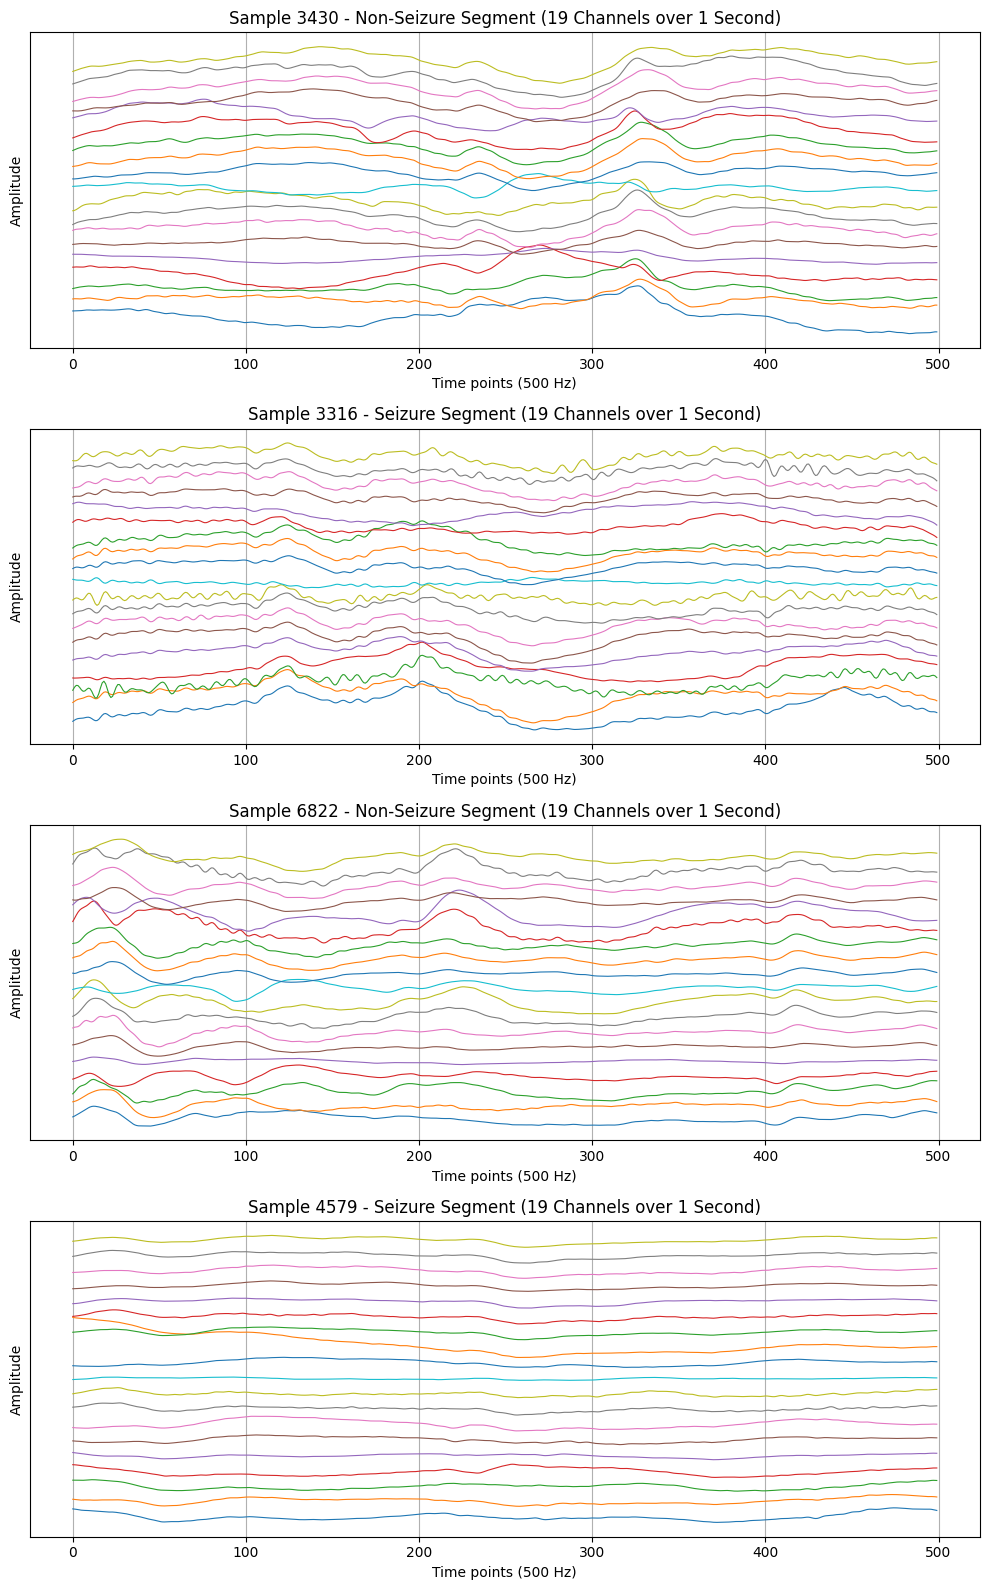

Sample raw segment visualization complete.


In [ ]:
# @title 5.2 Visualize Sample Raw Segments
#import matplotlib.pyplot as plt
#import numpy as np

# Ensure x_train and y_train_binary were loaded successfully in Step 4
if x_train is not None and y_train_binary is not None:

    print("\nVisualizing sample raw segments...")
    # Find indices of a few seizure and non-seizure samples from the training set
    seizure_indices = np.where(y_train_binary == 1)[0]
    non_seizure_indices = np.where(y_train_binary == 0)[0]

    # Determine how many samples to plot (e.g., 2 of each class, if available)
    num_samples_to_plot = min(2, len(seizure_indices), len(non_seizure_indices))

    if num_samples_to_plot > 0:
        # Randomly select indices for visualization
        seizure_sample_indices = np.random.choice(seizure_indices, num_samples_to_plot, replace=False)
        non_seizure_sample_indices = np.random.choice(non_seizure_indices, num_samples_to_plot, replace=False)

        # Create plots - one row for each sample (2*num_samples_to_plot rows), one column
        fig, axes = plt.subplots(num_samples_to_plot * 2, 1, figsize=(10, 4 * num_samples_to_plot * 2), squeeze=False)

        for i in range(num_samples_to_plot):
            # --- Plot a non-seizure sample ---
            sample_idx = non_seizure_sample_indices[i]
            segment_data = x_train[sample_idx, :, :] # Shape (channels, timepoints)

            # Plot each channel's time series individually within the subplot
            for channel in range(segment_data.shape[0]):
                 # Optional: Add a small offset to stack channels vertically for better visibility
                 offset = channel * np.max(np.abs(segment_data)) * 0.5 # Adjust offset multiplier as needed
                 axes[i*2, 0].plot(segment_data[channel, :] + offset, linewidth=0.8)

            axes[i*2, 0].set_title(f'Sample {sample_idx} - Non-Seizure Segment (19 Channels over 1 Second)')
            axes[i*2, 0].set_ylabel('Amplitude')
            axes[i*2, 0].set_xlabel('Time points (500 Hz)')
            axes[i*2, 0].grid(True)
            # Turn off y-axis ticks as offset makes absolute amplitude meaningless here
            axes[i*2, 0].set_yticks([])


            # --- Plot a seizure sample ---
            sample_idx = seizure_sample_indices[i]
            segment_data = x_train[sample_idx, :, :] # Shape (channels, timepoints)

            # Plot each channel's time series individually within the subplot
            for channel in range(segment_data.shape[0]):
                 # Optional: Add a small offset to stack channels vertically for better visibility
                 offset = channel * np.max(np.abs(segment_data)) * 0.5 # Adjust offset multiplier as needed
                 axes[i*2 + 1, 0].plot(segment_data[channel, :] + offset, linewidth=0.8)

            axes[i*2 + 1, 0].set_title(f'Sample {sample_idx} - Seizure Segment (19 Channels over 1 Second)')
            axes[i*2 + 1, 0].set_ylabel('Amplitude')
            axes[i*2 + 1, 0].set_xlabel('Time points (500 Hz)')
            axes[i*2 + 1, 0].grid(True)
            # Turn off y-axis ticks
            axes[i*2 + 1, 0].set_yticks([])


        plt.tight_layout()
        plt.show()

    else:
        print("Not enough samples in both classes to plot sample segments.")

    print("Sample raw segment visualization complete.")

else:
     print("Skipping sample segment visualization because data (x_train, y_train_binary) was not loaded successfully in Step 4.")

**Interpretation of Visualization 5.2: Sample Raw Segments (from NPY)**

This visualization displays example 1-second EEG segments for Non-Seizure and Seizure classes, showing the time course across 19 channels.

**Observation:** Non-Seizure segments appear more random and lower in amplitude, representing typical background EEG activity.
**Observation:** Seizure segments show distinct visual differences, including increased amplitude and noticeable synchronized, rhythmic patterns across multiple channels.
**Conclusion:** These visual differences in amplitude, synchronicity, and rhythmicity are the key patterns that machine learning models must learn to distinguish between the Non-Seizure and Seizure classes.
**Relevance for Seizure Detection:** The visualization confirms that the binary labels correspond to segments with visually distinct characteristics, suggesting the binary classification task is feasible based on these patterns. It also highlights that amplitude, frequency (implied by rhythmicity), and synchronicity are likely discriminative properties between the classes.


Visualizing amplitude distribution...


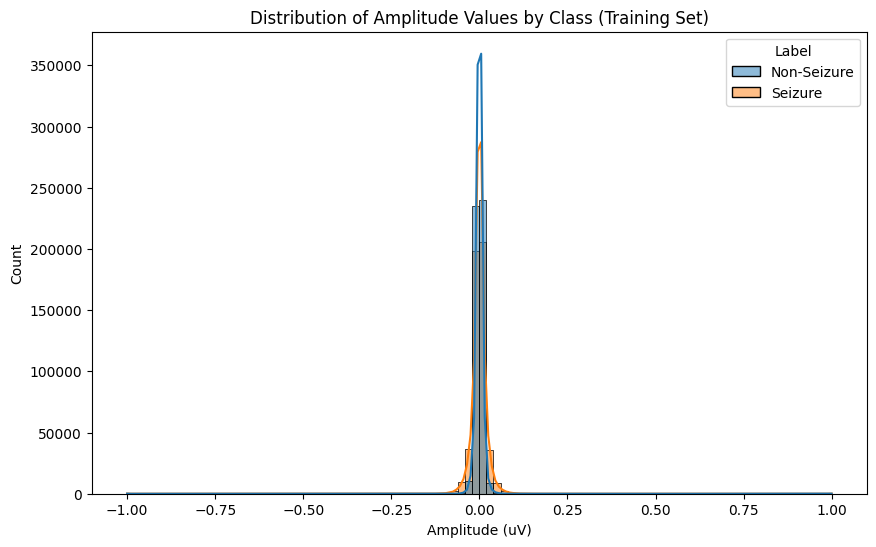

Amplitude distribution visualization complete.


In [ ]:
# @title 5.3 Visualize Amplitude Distribution
#import matplotlib.pyplot as plt
#import seaborn as sns
#import numpy as np
#import pandas as pd

# Ensure x_train and y_train_binary were loaded successfully in Step 4
if x_train is not None and y_train_binary is not None:

    print("\nVisualizing amplitude distribution...")

    # Flatten all amplitude values from all segments and channels in the training set
    all_amplitudes = x_train.flatten()

    # Create a corresponding label array (repeat each segment's label for all its time points * channels)
    labels_repeated = np.repeat(y_train_binary, x_train.shape[1] * x_train.shape[2])

    # Create a DataFrame for seaborn
    amplitude_df = pd.DataFrame({'Amplitude': all_amplitudes, 'Label': labels_repeated})
    # Convert Label to category for better plotting
    amplitude_df['Label'] = amplitude_df['Label'].astype('category')
    amplitude_df['Label'] = amplitude_df['Label'].cat.rename_categories({0: 'Non-Seizure', 1: 'Seizure'})


    # Plot histogram (can be dense, maybe sample data or use fewer bins)
    # Using fewer bins and potentially sampling for clarity if dataset is huge
    plot_data_size = min(len(amplitude_df), 1000000) # Limit data points for plotting efficiency
    amplitude_plot_df = amplitude_df.sample(plot_data_size) if len(amplitude_df) > plot_data_size else amplitude_df


    plt.figure(figsize=(10, 6))
    sns.histplot(data=amplitude_plot_df, x='Amplitude', hue='Label', kde=True, bins=100, common_norm=True)
    plt.title('Distribution of Amplitude Values by Class (Training Set)')
    plt.xlabel('Amplitude (uV)') # Assuming units are microvolts based on typical EEG
    plt.ylabel('Count')
    plt.show()

    # Optional: Violin plot can show distribution shape and density better
    # plt.figure(figsize=(8, 6))
    # sns.violinplot(x='Label', y='Amplitude', data=amplitude_plot_df)
    # plt.title('Violin Plot of Amplitude Distribution by Class (Training Set)')
    # plt.xlabel('Class')
    # plt.ylabel('Amplitude (uV)')
    # plt.show()

    print("Amplitude distribution visualization complete.")

else:
     print("Skipping amplitude distribution visualization because data (x_train, y_train_binary) was not loaded successfully in Step 4.")

**Interpretation of Visualization 5.3: Distribution of Amplitude Values by Class**

This histogram with overlaid Kernel Density Estimates (KDEs) shows the distribution of all individual amplitude values (across all time points and all channels) from all 1-second segments in the training set, separated by their binary label (Non-Seizure vs. Seizure).

**Observation:** Both the Non-Seizure (blue) and Seizure (orange) distributions are highly concentrated around zero amplitude, forming tall, narrow peaks. This is expected for EEG signals, which fluctuate around a baseline.
**Key Difference:** While both are centered at zero, the Seizure distribution (orange) appears slightly wider or has "heavier tails" than the Non-Seizure distribution (blue). This means that amplitude values further away from zero (both positive and negative) occur more frequently in seizure segments compared to non-seizure segments.
**Connecting to Raw Segments:** This quantitatively supports our visual observation from the sample segments (Visualization 5.2) where seizure segments often showed higher amplitude deflections.

**Why this is useful:**
This visualization confirms that amplitude is a potentially strong discriminative feature. Seizure activity tends to have larger deflections from the baseline.

**Feature Extraction:** Features that capture the spread of amplitude values, such as standard deviation, variance, mean absolute deviation, or interquartile range, are likely to be informative features for your traditional machine learning models (SVM, Random Forest).
**Model Learning:** The CNN model, processing the raw amplitude values directly, can also learn to recognize patterns characterized by these higher amplitudes.

This plot tells us that looking at how much the signal deviates from zero is a promising direction for distinguishing seizures from non-seizure activity.


Visualizing average Power Spectral Density (PSD) by class...


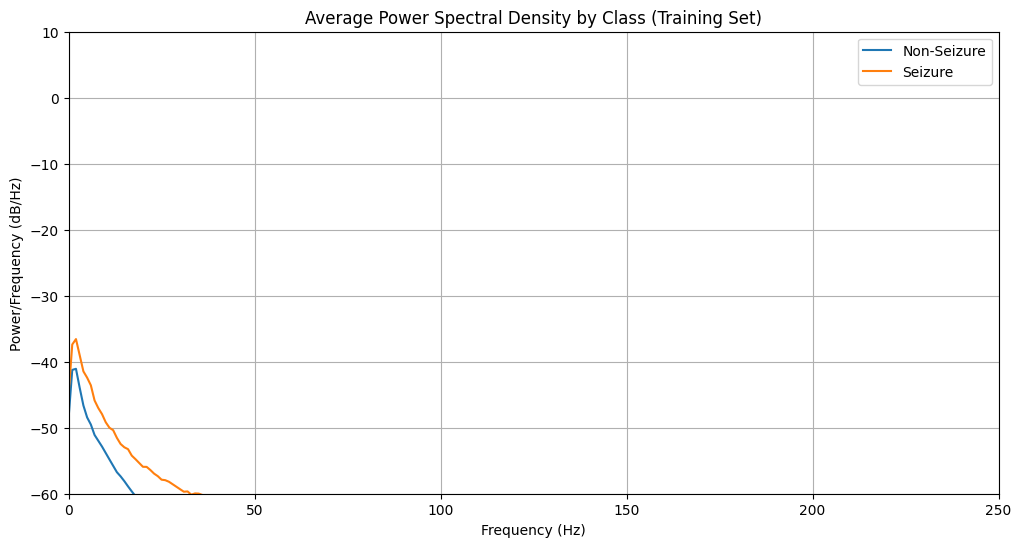

Average PSD visualization complete.


In [ ]:
# @title 5.4 Visualize Frequency Content (Average Power Spectral Density)
#import matplotlib.pyplot as plt
#import numpy as np
#from scipy.signal import welch : Used for calculating the power spectral density (PSD) of EEG signals.

# Ensure x_train and y_train_binary were loaded successfully in Step 4
if x_train is not None and y_train_binary is not None:

    print("\nVisualizing average Power Spectral Density (PSD) by class...")

    # Determine sampling frequency (500 Hz as per preprocess.py and segment shape)
    sfreq = 500
    nperseg = x_train.shape[2] # Use segment length for periodogram

    # Separate segments by class
    seizure_segments = x_train[y_train_binary == 1]
    non_seizure_segments = x_train[y_train_binary == 0]

    if len(seizure_segments) > 0 and len(non_seizure_segments) > 0:
        # Calculate PSD for each segment in each class
        # This can be computationally intensive. We average the PSDs later.
        # welch returns freqs and psd for the last dimension (time points)

        # Calculate PSDs for non-seizure segments
        all_non_seizure_psds = []
        for i in range(non_seizure_segments.shape[0]):
            for channel in range(non_seizure_segments.shape[1]):
                 freqs, psd = welch(non_seizure_segments[i, channel, :], sfreq, nperseg=nperseg, scaling='density')
                 all_non_seizure_psds.append(psd)
        all_non_seizure_psds = np.array(all_non_seizure_psds)

        # Calculate PSDs for seizure segments
        all_seizure_psds = []
        for i in range(seizure_segments.shape[0]):
            for channel in range(seizure_segments.shape[1]):
                 freqs, psd = welch(seizure_segments[i, channel, :], sfreq, nperseg=nperseg, scaling='density')
                 all_seizure_psds.append(psd)
        all_seizure_psds = np.array(all_seizure_psds)

        # Calculate the average PSD across all segments/channels within each class
        average_non_seizure_psd = np.mean(all_non_seizure_psds, axis=0)
        average_seizure_psd = np.mean(all_seizure_psds, axis=0)

        # Plot the average PSDs
        plt.figure(figsize=(12, 6))
        plt.plot(freqs, 10 * np.log10(average_non_seizure_psd), label='Non-Seizure') # Plot in dB
        plt.plot(freqs, 10 * np.log10(average_seizure_psd), label='Seizure') # Plot in dB
        plt.title('Average Power Spectral Density by Class (Training Set)')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power/Frequency (dB/Hz)')
        plt.xlim([0, sfreq / 2]) # Show up to Nyquist frequency
        plt.ylim([-60, 10]) # Adjust limits based on your data scale
        plt.legend()
        plt.grid(True)
        plt.show()

        print("Average PSD visualization complete.")

    else:
        print("Not enough samples in both classes to plot average PSD.")

else:
     print("Skipping average PSD visualization because data (x_train, y_train_binary) was not loaded successfully in Step 4.")

**Interpretation of Visualization 5.4: Average Power Spectral Density by Class**

This plot shows how the average power of the EEG signal is distributed across different frequencies for the Non-Seizure (blue line) and Seizure (orange line) classes in your training set. The y-axis is on a logarithmic scale (dB/Hz), which represents power.

**Observation:**
For both classes, the power is highest at the very low frequencies and generally decreases as the frequency increases. This is a typical characteristic of EEG signals.
**Observation:** Crucially, the orange line (Seizure) shows consistently higher power than the blue line (Non-Seizure) across a wide range of frequencies, particularly in the lower frequencies (roughly below 30-40 Hz).
**Observation:** The difference in power between the classes appears most significant in the lower frequency bands (Delta, Theta, Alpha, and possibly lower Beta).
**Connecting to Previous Observations:** This plot provides a quantitative explanation for the higher amplitude and often more rhythmic appearance of seizure segments in the raw visualization (Visualization 5.2). Higher amplitude signals contribute to higher overall power. Rhythmic activity at specific frequencies (like rhythmic spiking) shows up as elevated power in the PSD around those frequencies.

**Why this is useful:**
This visualization strongly suggests that frequency-domain features, especially measures of power within specific EEG bands, will be highly effective in discriminating between seizure and non-seizure segments.

**Feature Extraction:** Calculating the absolute and relative power in standard EEG bands (Delta, Theta, Alpha, Beta, Gamma) as implemented in our planned Step 5.1 is directly supported by this visualization. These features are likely to have significant differences between the classes.
**Model Learning:** Both traditional models and the CNN can leverage this information. Traditional models use the calculated band power features. A CNN, processing the time-series data, can learn filters that are essentially sensitive to specific frequencies and patterns in the frequency domain.

This plot is a clear indicator that frequency content is a key differentiator in this dataset.


Visualizing average band power by channel and class...

Plotting average band power per channel by frequency band and class...


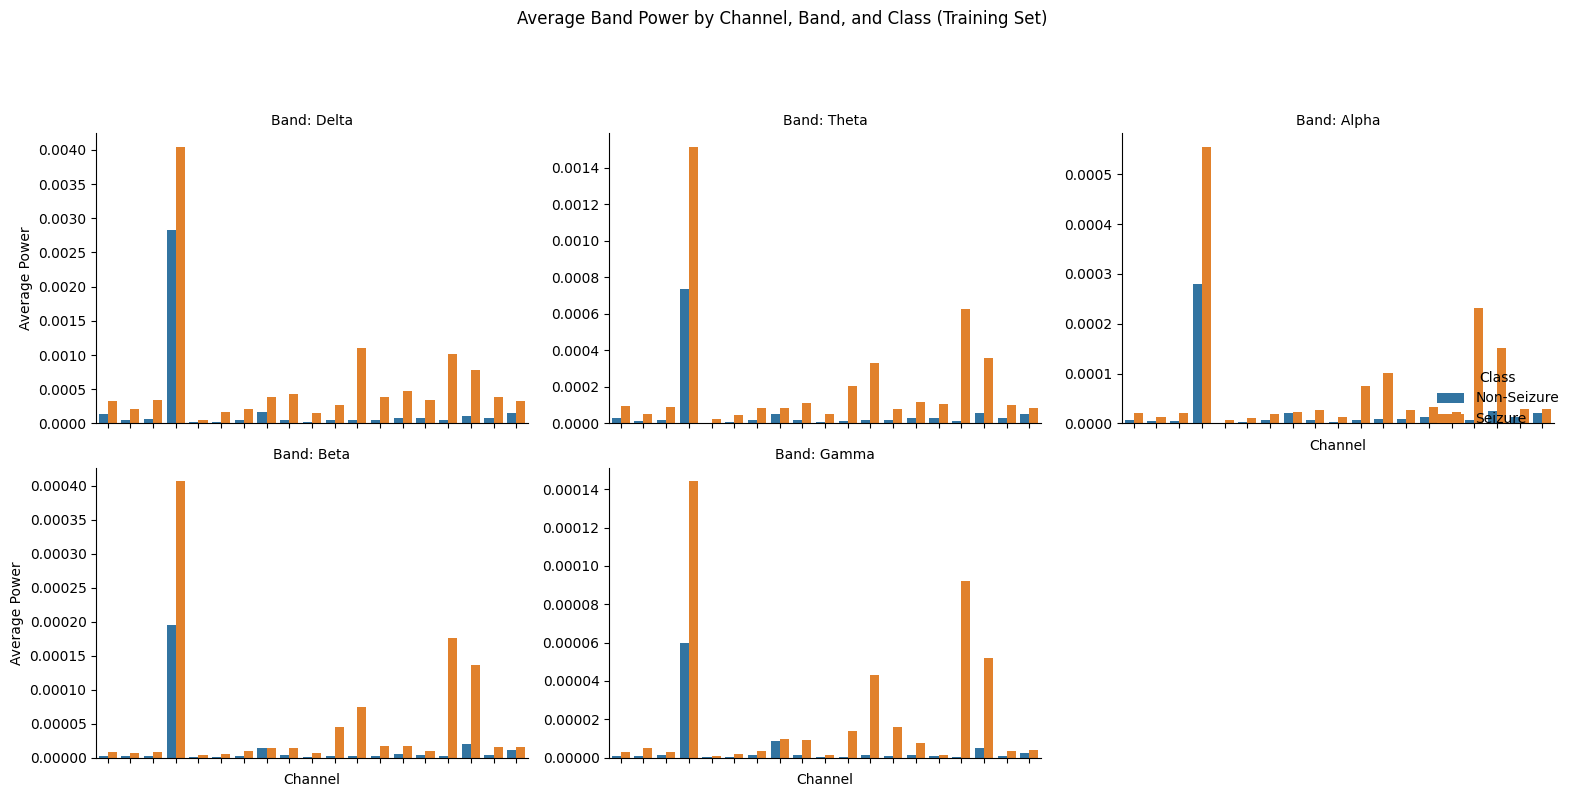

Average band power visualization complete.


In [ ]:
# @title 5.5 Visualize Channel Activity Differences (Average Band Power)
#import matplotlib.pyplot as plt
#import numpy as np
#from scipy.signal import welch
#import pandas as pd
#import seaborn as sns

# Ensure x_train and y_train_binary were loaded successfully in Step 4
if x_train is not None and y_train_binary is not None:

    print("\nVisualizing average band power by channel and class...")

    sfreq = 500
    nperseg = x_train.shape[2] # Use segment length for periodogram

    # Define EEG bands
    eeg_bands = {'Delta': (1, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 13),
                 'Beta': (13, 30),
                 'Gamma': (30, 70)}

    # Separate segments by class
    seizure_segments = x_train[y_train_binary == 1]
    non_seizure_segments = x_train[y_train_binary == 0]

    if len(seizure_segments) > 0 and len(non_seizure_segments) > 0:

        def calculate_average_band_power_per_channel(segments, sfreq, eeg_bands, nperseg):
            """Calculates average band power for each channel across multiple segments."""
            n_segments, n_channels, n_times = segments.shape
            band_power_data = {band: np.zeros(n_channels) for band in eeg_bands}

            for i in range(n_segments):
                for channel in range(n_channels):
                    channel_data = segments[i, channel, :]
                    freqs, psd = welch(channel_data, sfreq, nperseg=nperseg, scaling='density')

                    for band, (fmin, fmax) in eeg_bands.items():
                        band_indices = np.where((freqs >= fmin) & (freqs <= fmax))[0]
                        if band_indices.size > 0:
                            band_power = np.sum(psd[band_indices])
                            band_power_data[band][channel] += band_power

            # Average across segments
            for band in eeg_bands:
                band_power_data[band] /= n_segments

            return band_power_data

        # Calculate average band power for both classes
        avg_non_seizure_band_power = calculate_average_band_power_per_channel(non_seizure_segments, sfreq, eeg_bands, nperseg)
        avg_seizure_band_power = calculate_average_band_power_per_channel(seizure_segments, sfreq, eeg_bands, nperseg)

        # Prepare data for plotting
        plot_data = []
        channel_names = [f'Ch{i+1}' for i in range(x_train.shape[1])] # Generic channel names

        for band in eeg_bands:
            for i in range(x_train.shape[1]):
                 plot_data.append({'Channel': channel_names[i],
                                   'Band': band,
                                   'Average Power': avg_non_seizure_band_power[band][i],
                                   'Class': 'Non-Seizure'})
                 plot_data.append({'Channel': channel_names[i],
                                   'Band': band,
                                   'Average Power': avg_seizure_band_power[band][i],
                                   'Class': 'Seizure'})

        plot_df = pd.DataFrame(plot_data)

        # Plot using seaborn catplot (FacetGrid)
        print("\nPlotting average band power per channel by frequency band and class...")
        g = sns.catplot(data=plot_df, x='Channel', y='Average Power',
                        hue='Class', col='Band', kind='bar', sharey=False, col_wrap=3, height=4, aspect=1.2)
        g.fig.suptitle('Average Band Power by Channel, Band, and Class (Training Set)', y=1.02)
        g.set_titles("Band: {col_name}")
        g.set_xticklabels(rotation=90)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()


        print("Average band power visualization complete.")

    else:
        print("Not enough samples in both classes to plot average band power.")


else:
     print("Skipping average band power visualization because data (x_train, y_train_binary) was not loaded successfully in Step 4.")

**Interpretation of Visualization 5.5: Average Band Power by Channel, Band, and Class**

This set of plots breaks down the frequency-domain differences between seizure and non-seizure classes across individual channels and standard EEG frequency bands (Delta, Theta, Alpha, Beta, and Gamma). For each band, you see a bar plot showing the average power for each of the 19 channels, with separate bars for Non-Seizure (blue/teal) and Seizure (orange) classes.

**Overall Trend:** Across nearly all bands and most channels, the orange bars (Seizure) are significantly taller than the blue/teal bars (Non-Seizure). This is a detailed view that strongly reinforces the finding from the average PSD plot (Visualization 5.4) that seizure segments have substantially higher power than non-seizure segments.

**Most Discriminative Bands:**
**Delta (1-4 Hz):** Shows a large and consistent difference between seizure and non-seizure power across many channels. The seizure bars are notably higher.
**Theta (4-8 Hz):** Similar to Delta, the Theta band also shows a significant and consistent elevation in average power during seizure segments compared to non-seizure segments across a wide range of channels.
**Alpha (8-13 Hz), Beta (13-30 Hz), Gamma (30-70 Hz):** These bands also show higher average power in seizure segments, but the relative difference compared to the non-seizure power might be less dramatic or consistent across all channels than in the Delta and Theta bands. There are some channels where the difference is prominent, but also channels where it's smaller.

**Potentially Involved Channels:** While the x-axis labels are generic "Channel" numbers (Ch1 to Ch19), the plots suggest that several channels consistently show large differences in average band power, especially in the Delta and Theta bands. Without knowing the electrode map for these 19 channels, we can't link them to specific scalp locations (like Fp1, Fp2, etc.), but it indicates that seizure activity is manifesting with increased low-frequency power across multiple recording sites.

**Why this is useful:**
This visualization provides strong evidence that average power in the Delta and Theta frequency bands, calculated per channel, are likely to be among the most discriminative features for your seizure detection task. Features derived from these bands and channels should have high predictive power.

**Feature Importance:** When you later perform feature selection (Step 8) or examine feature importance from models like Random Forest, you can expect features related to Delta and Theta power from multiple channels to rank highly.
**Model Focus:** This insight helps understand what kind of patterns the models are leveraging. CNNs will learn filters sensitive to activity in these frequency ranges and channels. Traditional models will rely directly on the computed band power values.

This plot provides a detailed frequency-spatial view of the differences between classes, guiding our understanding of feature relevance.


Visualizing segment-wise statistics distribution by class...

Plotting distributions of segment-wise statistics by class...


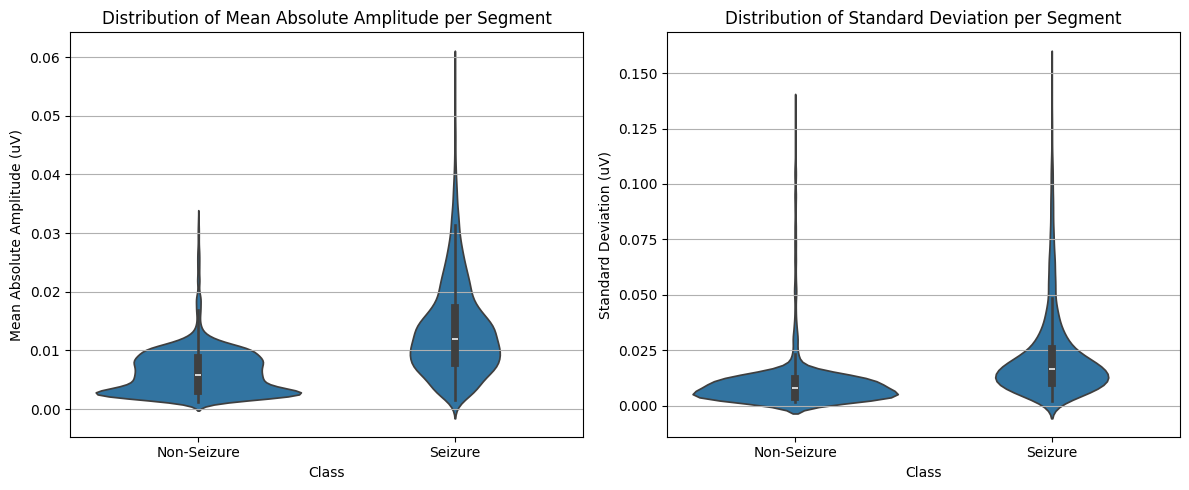

Segment-wise statistics visualization complete.


In [ ]:
# @title 5.6 Visualize Segment Statistics Distribution
#import matplotlib.pyplot as plt
#import seaborn as sns
#import numpy as np
#import pandas as pd

# Ensure x_train and y_train_binary were loaded successfully in Step 4
if x_train is not None and y_train_binary is not None:

    print("\nVisualizing segment-wise statistics distribution by class...")

    # Calculate statistics for each segment
    segment_mean_abs = np.mean(np.abs(x_train), axis=(1, 2)) # Mean of absolute values across channels and time
    segment_std = np.std(x_train, axis=(1, 2)) # Standard deviation across channels and time
    # Add other segment-wise statistics here if desired

    # Create a DataFrame for seaborn
    segment_stats_df = pd.DataFrame({
        'Mean Absolute Amplitude': segment_mean_abs,
        'Standard Deviation': segment_std,
        'Label': y_train_binary
    })

    # Convert Label to category for better plotting
    segment_stats_df['Label'] = segment_stats_df['Label'].astype('category')
    segment_stats_df['Label'] = segment_stats_df['Label'].cat.rename_categories({0: 'Non-Seizure', 1: 'Seizure'})


    # Plot distributions using violin plots or box plots
    print("\nPlotting distributions of segment-wise statistics by class...")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.violinplot(x='Label', y='Mean Absolute Amplitude', data=segment_stats_df)
    plt.title('Distribution of Mean Absolute Amplitude per Segment')
    plt.xlabel('Class')
    plt.ylabel('Mean Absolute Amplitude (uV)')
    plt.grid(axis='y')

    plt.subplot(1, 2, 2)
    sns.violinplot(x='Label', y='Standard Deviation', data=segment_stats_df)
    plt.title('Distribution of Standard Deviation per Segment')
    plt.xlabel('Class')
    plt.ylabel('Standard Deviation (uV)')
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

    print("Segment-wise statistics visualization complete.")

else:
     print("Skipping segment-wise statistics visualization because data (x_train, y_train_binary) was not loaded successfully in Step 4.")

**Interpretation of Visualization 5.6: Distribution of Segment Statistics**

These two violin plots compare the distribution of calculated statistics (Mean Absolute Amplitude and Standard Deviation, averaged across channels and time points within each segment) between the Non-Seizure and Seizure classes in the training set. Violin plots show the shape of the distribution and density of data points.

**Distribution of Mean Absolute Amplitude per Segment:**
**Observation:** The violin plot for Seizure segments (orange distribution on the right) is significantly shifted upwards and is wider at higher amplitude values compared to the Non-Seizure segments (blue/teal distribution on the left). The median and interquartile range (the box inside the violin) are clearly higher for seizure segments.
**Conclusion:** Seizure segments, on average, have a much higher mean absolute amplitude than non-seizure segments. The signal is further away from zero, on average, during seizures.

**Distribution of Standard Deviation per Segment:**
**Observation:** Similarly, the violin plot for Seizure segments is markedly shifted upwards and is wider at higher standard deviation values compared to the Non-Seizure segments. The median and interquartile range are also clearly higher for seizure segments.
**Conclusion:** Seizure segments tend to have a significantly higher standard deviation than non-seizure segments. This means the amplitude values within seizure segments vary more widely, indicating more intense or variable activity.

**Why this is useful:**
These visualizations quantitatively confirm that simple segment-level statistics related to amplitude and variability are powerful discriminators between seizure and non-seizure classes.

**Feature Importance:** Mean Absolute Amplitude and Standard Deviation (calculated per segment, or per channel within a segment as in our Step 5.1 feature extraction) are expected to be highly informative features for traditional models.
**Model Learning:** Models can easily learn to separate classes based on thresholds or patterns involving these statistics.

**Summary of Step 5 Visualizations:**
By completing this detailed visualization step, you have gained crucial insights into your data:

**Class Balance (5.1):** The training set is well-balanced, making standard accuracy a meaningful metric.
**Raw Segment Patterns (5.2):** Visually confirmed that seizure segments often exhibit higher amplitude, increased synchronicity, and more rhythmic patterns compared to non-seizure segments.
**Amplitude Distribution (5.3 & 5.6):** Quantitatively showed that seizure segments have a wider distribution of amplitude values, higher mean absolute amplitude per segment, and higher standard deviation per segment.
**Frequency Content (5.4 & 5.5):** Demonstrated that seizure segments have higher power across various frequencies, particularly showing significantly elevated average power in the Delta and Theta bands across multiple channels.

These visualizations collectively provide strong evidence that the data contains clear patterns distinguishing seizure from non-seizure activity, and they highlight which types of features (amplitude-based, variability-based, and frequency-based, especially low-frequency band power) are likely to be most effective for the seizure detection task. This solidifies the foundation for feature extraction and model training.
Now that you have completed the detailed data visualization step and have a strong understanding of the data characteristics, we are ready to proceed with preparing the data for the specific models and then training them.

In [ ]:
# @title 6.1 Prepare Data for CNN
# Ensure x_train and x_test were loaded successfully in Step 4
if x_train is not None and x_test is not None and y_train_binary is not None and y_test_binary is not None:
    # The x_train and x_test arrays are already in the shape (samples, channels, timepoints)
    # This is a common format for time-series data in deep learning (channels_first).
    # We will use these arrays directly for the CNN model.

    x_train_cnn = x_train
    x_test_cnn = x_test

    y_train_cnn = y_train_binary
    y_test_cnn = y_test_binary

    print(f"Data shape for CNN (channels_first): x_train_cnn {x_train_cnn.shape}, x_test_cnn {x_test_cnn.shape}")
    print(f"Labels shape for CNN: y_train_cnn {y_train_cnn.shape}, y_test_cnn {y_test_cnn.shape}")
    print("\nData prepared for CNN.")

else:
    print("Skipping CNN data preparation because data (x_train, x_test, y_train_binary, y_test_binary) was not loaded successfully in Step 4.")
    x_train_cnn, x_test_cnn = None, None
    y_train_cnn, y_test_cnn = None, None

Data shape for CNN (channels_first): x_train_cnn (7011, 19, 500), x_test_cnn (779, 19, 500)
Labels shape for CNN: y_train_cnn (7011,), y_test_cnn (779,)

Data prepared for CNN.


In [ ]:
# @title 6.2 Feature Extraction for Traditional Models (Optimized)
#import numpy as np
#from scipy.signal import welch
#from scipy.stats import skew, kurtosis : sed for calculating skewness and kurtosis of EEG signals during feature extraction.
#import pandas as pd
# from tqdm.notebook import tqdm : A progress bar library for Jupyter/Colab notebooks, used to track the progress of loops.
# from joblib import Parallel, delayed # For parallel processing : Used for parallelizing tasks across multiple CPU cores, such as feature extraction.
# import os : to determine number of CPU cores

# Ensure x_train and x_test were loaded successfully in Step 4
if x_train is not None and x_test is not None and y_train_binary is not None and y_test_binary is not None:

    def extract_segment_features_optimized(segment, sfreq):
        """
        Extract a richer set of features from a single EEG segment (n_channels, n_times).
        Designed to be used with joblib for parallel processing.

        Args:
            segment (np.ndarray): A single segment of shape (n_channels, n_times).
            sfreq (float): Sampling frequency.

        Returns:
            np.ndarray: A 1D array of extracted features.
        """
        features = []
        n_channels, n_times = segment.shape

        eeg_bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30), 'Gamma': (30, 70)}

        for i in range(n_channels):
            channel_data = segment[i, :]

            # Time-domain features (expanded)
            features.extend([
                np.mean(channel_data), np.std(channel_data), skew(channel_data),
                kurtosis(channel_data), np.percentile(channel_data, 75) - np.percentile(channel_data, 25),
                np.max(channel_data), np.min(channel_data), np.max(np.abs(channel_data)),
                np.mean(np.abs(channel_data)), np.sum(np.abs(channel_data))
            ])

            # Frequency-domain features (Band Power and Relative Band Power)
            freqs, psd = welch(channel_data, sfreq, nperseg=n_times, scaling='density')

            total_power = np.sum(psd)
            if total_power == 0: total_power = 1e-9

            for band, (fmin, fmax) in eeg_bands.items():
                band_indices = np.where((freqs >= fmin) & (freqs <= fmax))[0]
                if band_indices.size > 0:
                     band_power = np.sum(psd[band_indices])
                     features.extend([band_power, band_power / total_power])
                else:
                     features.extend([0.0, 0.0])

        return np.array(features)

    # Determine sampling frequency (500 Hz)
    sfreq = 500

    # Determine number of CPU cores to use for parallel processing
    # n_jobs=-1 means using all available CPU cores
    n_jobs = -1
    print(f"Using {os.cpu_count()} CPU cores for parallel processing (n_jobs={n_jobs}).")


    # Apply feature extraction to training data using parallel processing and progress bar
    print("Extracting features from training segments for traditional models (Optimized)...")
    # Use joblib.Parallel to run the feature extraction function in parallel
    # Wrap the loop with tqdm for a progress bar
    X_train_features = np.array(Parallel(n_jobs=n_jobs)(
        delayed(extract_segment_features_optimized)(x_train[i, :, :], sfreq)
        for i in tqdm(range(x_train.shape[0]), desc="Extracting Train Features")
    ))

    # Apply feature extraction to testing data using parallel processing and progress bar
    print("\nExtracting features from testing segments for traditional models (Optimized)...")
    X_test_features = np.array(Parallel(n_jobs=n_jobs)(
        delayed(extract_segment_features_optimized)(x_test[i, :, :], sfreq)
        for i in tqdm(range(x_test.shape[0]), desc="Extracting Test Features ")
    ))

    print("\nFeature extraction process complete.")
    print(f"Extracted X_train_features shape (samples, features): {X_train_features.shape}")
    print(f"Extracted X_test_features shape (samples, features): {X_test_features.shape}")

    # The binary labels for these features are the same as the binary labels for the segments
    y_train_features = y_train_binary
    y_test_features = y_test_binary

    print("Labels for traditional models assigned.")
    print(f"y_train_features shape: {y_train_features.shape}")
    print(f"y_test_features shape: {y_test_features.shape}")


else:
    print("Skipping feature extraction because data (x_train, x_test, y_train_binary, y_test_binary) was not loaded successfully in Step 4.")
    X_train_features, X_test_features = None, None
    y_train_features, y_test_features = None, None # Ensure labels are also None if features failed

# At the end of Step 6.2, you will have:
# X_train_features, y_train_features (for SVM/RF training)
# X_test_features, y_test_features (for SVM/RF testing)
# x_train_cnn, y_train_cnn (for CNN training) - from Step 6.1
# x_test_cnn, y_test_cnn (for CNN testing) - from Step 6.1

Using 2 CPU cores for parallel processing (n_jobs=-1).
Extracting features from training segments for traditional models (Optimized)...


Extracting Train Features:   0%|          | 0/7011 [00:00<?, ?it/s]


Extracting features from testing segments for traditional models (Optimized)...


Extracting Test Features :   0%|          | 0/779 [00:00<?, ?it/s]


Feature extraction process complete.
Extracted X_train_features shape (samples, features): (7011, 380)
Extracted X_test_features shape (samples, features): (779, 380)
Labels for traditional models assigned.
y_train_features shape: (7011,)
y_test_features shape: (779,)


In [ ]:
# @title 7. Initial Model Training & Evaluation (Before Feature Selection)
#import numpy as np
#from sklearn.svm import SVC : A Support Vector Machine (SVM) classifier for binary or multi-class classification tasks.
#from sklearn.ensemble import RandomForestClassifier : A Random Forest classifier used for ensemble-based classification.
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report : Provides functions for evaluating model performance, such as accuracy, precision, recall, and F1-score.
#import tensorflow as tf : A deep learning library used for building and training neural networks, such as CNNs.
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#import time : Provides functions for measuring execution time, useful for benchmarking model training and evaluation.
#import pandas as pd # Import pandas here for potential future use/consistency

# --- Initialize dictionary to store initial results ---
# This dictionary will hold the performance metrics for SVM, RF, and CNN
# It needs to be defined at a scope where all sub-parts of Step 7 can access it
# Running this cell will initialize/reset it.
initial_results = {}
print("Initialized 'initial_results' dictionary to store model performances.")


# --- Ensure Data is Available ---
# Checking all necessary data for all models in this main block
if (X_train_features is None or y_train_features is None or
    X_test_features is None or y_test_features is None or
    x_train_cnn is None or y_train_cnn is None or
    x_test_cnn is None or y_test_cnn is None):
    print("Error: Data or features not available. Please ensure Steps 4 and 6 were run successfully.")
    # Ensure models are None if data is missing to prevent errors in sub-steps
    svm_model = None
    rf_model = None
    cnn_model = None
    # Skip the rest of the step if data is missing
else:
    print("Required data confirmed available for Step 7.")

# Note: The actual training and evaluation code for each model is in the sub-steps below.
# You need to run this cell first to initialize initial_results, then run the sub-step cells in order.

Initialized 'initial_results' dictionary to store model performances.
Required data confirmed available for Step 7.


In [ ]:
# @title 7.1 Train and Evaluate Support Vector Machine (SVM)
# Ensure data is available and initial_results dictionary is initialized
if 'initial_results' in locals() and X_train_features is not None and y_train_features is not None and X_test_features is not None and y_test_features is not None:
    print("\n--- Training Support Vector Machine (SVM) ---")

    svm_model = SVC(kernel='rbf', random_state=42)

    print("Training SVM model...")
    start_time = time.time()
    svm_model.fit(X_train_features, y_train_features)
    end_time = time.time()
    print(f"SVM training complete in {end_time - start_time:.2f} seconds.")

    print("\n--- Evaluating SVM on the test set ---")
    y_pred_svm = svm_model.predict(X_test_features)

    accuracy_svm = accuracy_score(y_test_features, y_pred_svm)
    precision_svm = precision_score(y_test_features, y_pred_svm)
    recall_svm = recall_score(y_test_features, y_pred_svm)
    f1_svm = f1_score(y_test_features, y_pred_svm)

    print(f"SVM Initial Performance (Before Feature Selection):")
    print(f"  Accuracy: {accuracy_svm:.4f}")
    print(f"  Precision: {precision_svm:.4f}")
    print(f"  Recall: {recall_svm:.4f}")
    print(f"  F1-score: {f1_svm:.4f}")

    # --- Save SVM results to the dictionary ---
    initial_results['SVM_Initial'] = {
        'accuracy': accuracy_svm,
        'precision': precision_svm,
        'recall': recall_svm,
        'f1': f1_svm
    }
    print("\nSVM training and evaluation complete. Results saved to 'initial_results'.")

else:
    print("Skipping SVM training/evaluation. Ensure Step 7 main cell is run and data is available.")
    svm_model = None # Ensure model is None if skipped


--- Training Support Vector Machine (SVM) ---
Training SVM model...
SVM training complete in 5.93 seconds.

--- Evaluating SVM on the test set ---
SVM Initial Performance (Before Feature Selection):
  Accuracy: 0.8883
  Precision: 0.9395
  Recall: 0.8127
  F1-score: 0.8715

SVM training and evaluation complete. Results saved to 'initial_results'.


In [ ]:
# @title 7.2 Train and Evaluate Random Forest
# Ensure data is available and initial_results dictionary is initialized
if 'initial_results' in locals() and X_train_features is not None and y_train_features is not None and X_test_features is not None and y_test_features is not None:
    print("\n--- Training Random Forest ---")

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    print("Training Random Forest model...")
    start_time = time.time()
    rf_model.fit(X_train_features, y_train_features)
    end_time = time.time()
    print(f"Random Forest training complete in {end_time - start_time:.2f} seconds.")

    print("\n--- Evaluating Random Forest on the test set ---")
    y_pred_rf = rf_model.predict(X_test_features)

    accuracy_rf = accuracy_score(y_test_features, y_pred_rf)
    precision_rf = precision_score(y_test_features, y_pred_rf)
    recall_rf = recall_score(y_test_features, y_pred_rf)
    f1_rf = f1_score(y_test_features, y_pred_rf)

    print(f"Random Forest Initial Performance (Before Feature Selection):")
    print(f"  Accuracy: {accuracy_rf:.4f}")
    print(f"  Precision: {precision_rf:.4f}")
    print(f"  Recall: {recall_rf:.4f}")
    print(f"  F1-score: {f1_rf:.4f}")

    # --- Save Random Forest results to the dictionary ---
    initial_results['RandomForest_Initial'] = {
        'accuracy': accuracy_rf,
        'precision': precision_rf,
        'recall': recall_rf,
        'f1': f1_rf
    }
    print("\nRandom Forest training and evaluation complete. Results saved to 'initial_results'.")

else:
    print("Skipping Random Forest training/evaluation. Ensure Step 7 main cell is run and data is available.")
    rf_model = None # Ensure model is None if skipped


--- Training Random Forest ---
Training Random Forest model...
Random Forest training complete in 10.82 seconds.

--- Evaluating Random Forest on the test set ---
Random Forest Initial Performance (Before Feature Selection):
  Accuracy: 0.9628
  Precision: 0.9665
  Recall: 0.9532
  F1-score: 0.9598

Random Forest training and evaluation complete. Results saved to 'initial_results'.


In [ ]:
# @title 7.3 Train and Evaluate Convolutional Neural Network (CNN)
# Ensure data is available and initial_results dictionary is initialized
if 'initial_results' in locals() and x_train_cnn is not None and y_train_cnn is not None and x_test_cnn is not None and y_test_cnn is not None:
    print("\n--- Training Convolutional Neural Network (CNN) on GPU (Revised Architecture) ---")

    # Ensure TensorFlow can see and is using the GPU
    gpu_available = tf.config.list_physical_devices('GPU')
    if gpu_available:
        print(f"GPU available: {gpu_available}")
        for gpu in gpu_available:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU setup complete. TensorFlow will use the GPU.")
    else:
        print("No GPU available. CNN training will revert to CPU and will be very slow.")


    # Reshape data for channels_last format (samples, timepoints, channels, 1)
    x_train_cnn_reshaped = np.transpose(x_train_cnn, (0, 2, 1))
    x_test_cnn_reshaped = np.transpose(x_test_cnn, (0, 2, 1))

    x_train_cnn_reshaped = x_train_cnn_reshaped.reshape(x_train_cnn_reshaped.shape[0], x_train_cnn_reshaped.shape[1], x_train_cnn_reshaped.shape[2], 1)
    x_test_cnn_reshaped = x_test_cnn_reshaped.reshape(x_test_cnn_reshaped.shape[0], x_test_cnn_reshaped.shape[1], x_test_cnn_reshaped.shape[2], 1)

    input_shape_cnn = (x_train_cnn_reshaped.shape[1], x_train_cnn_reshaped.shape[2], 1) # (timepoints, channels, 1) -> (500, 19, 1)


    # Define the CNN model architecture (Corrected)
    cnn_model = Sequential()
    cnn_model.add(Input(shape=input_shape_cnn))
    cnn_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    # FIX: Adjusted kernel size for the third Conv2D layer
    cnn_model.add(Conv2D(filters=128, kernel_size=(3, 1), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Pooling (2,2) from (121, 2) -> (60, 1) after Conv2D(3,1)

    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    print("\nCNN Model Summary (Revised):")
    cnn_model.summary()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=0.0001, mode='max')


    # Train the CNN model
    print("\nTraining CNN on GPU (Revised Architecture)...")
    start_time = time.time()
    history = cnn_model.fit(x_train_cnn_reshaped, y_train_cnn,
                            epochs=100,
                            batch_size=64,
                            validation_split=0.2,
                            callbacks=[early_stopping, reduce_lr],
                            verbose=1)
    end_time = time.time()
    print(f"\nCNN training complete in {end_time - start_time:.2f} seconds on GPU.")

    print("\n--- Evaluating CNN on the test set ---")
    # Evaluate CNN performance
    loss_cnn, accuracy_cnn = cnn_model.evaluate(x_test_cnn_reshaped, y_test_cnn, verbose=0)

    # Get predictions for other metrics
    y_pred_cnn_proba = cnn_model.predict(x_test_cnn_reshaped, verbose=0)
    y_pred_cnn = (y_pred_cnn_proba > 0.5).astype(int)

    accuracy_cnn = accuracy_score(y_test_cnn, y_pred_cnn) # Recalculate accuracy from predictions for consistency with other metrics
    precision_cnn = precision_score(y_test_cnn, y_pred_cnn)
    recall_cnn = recall_score(y_test_cnn, y_pred_cnn)
    f1_cnn = f1_score(y_test_cnn, y_pred_cnn)


    print(f"CNN Initial Performance (Before Feature Selection):")
    print(f"  Accuracy: {accuracy_cnn:.4f}")
    print(f"  Precision: {precision_cnn:.4f}")
    print(f"  Recall: {recall_cnn:.4f}")
    print(f"  F1-score: {f1_cnn:.4f}")

    # --- Save CNN results to the dictionary ---
    initial_results['CNN_Initial'] = {
        'accuracy': accuracy_cnn,
        'precision': precision_cnn,
        'recall': recall_cnn,
        'f1': f1_cnn
    }
    print("\nCNN training and evaluation complete. Results saved to 'initial_results'.")

else:
    print("Skipping CNN training/evaluation. Ensure Step 7 main cell is run and data is available.")
    cnn_model = None # Ensure model is None if skipped


--- Training Convolutional Neural Network (CNN) on GPU (Revised Architecture) ---
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU setup complete. TensorFlow will use the GPU.

CNN Model Summary (Revised):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 496, 15, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 496, 15, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 248, 7, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 246, 5, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 246, 5, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 123, 2, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 121, 2, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 121, 2, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 60, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       983,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,225 (3.92 MB)

 Trainable params: 1,027,777 (3.92 MB)

 Non-trainable params: 448 (1.75 KB)


Training CNN on GPU (Revised Architecture)...
Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.7604 - loss: 0.8346 - val_accuracy: 0.5061 - val_loss: 1.5388 - learning_rate: 0.0010
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8758 - loss: 0.3295 - val_accuracy: 0.5061 - val_loss: 3.6666 - learning_rate: 0.0010
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8908 - loss: 0.2574 - val_accuracy: 0.5061 - val_loss: 7.3519 - learning_rate: 0.0010
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9046 - loss: 0.2246 - val_accuracy: 0.5068 - val_loss: 7.7268 - learning_rate: 0.0010
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9121 - loss: 0.1925 - val_accuracy: 0.5103 - val_loss: 11.1802 - learning_rate: 0.0010
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9176 - loss: 0.1767 - val_accuracy: 0.5609 - val_loss: 6.2530 - learning_rate: 0.0010
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 

## Step 8: Feature Scaling and Selection

Apply feature scaling to standardize the range of the 1D features. Then, apply a feature selection technique to select a subset of the most relevant features based on their relationship with the target variable.

In [ ]:
# @title 8.1 Feature Scaling
#import numpy as np
#from sklearn.preprocessing import StandardScaler : Used for scaling features to have zero mean and unit variance during preprocessing.

# Ensure 1D features are available from Step 6.2
if X_train_features is None or X_test_features is None:
    print("Error: 1D features not available. Please ensure Step 6.2 was run successfully.")
    X_train_scaled = None
    X_test_scaled = None
else:
    print("--- Starting Feature Scaling (Step 8.1) ---")
    print("Scaling features using StandardScaler...")

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data's features and transform both training and testing features
    # It is crucial to fit the scaler ONLY on the training data
    # and then use that fitted scaler to transform the test data.
    # This prevents information leakage from the test set into the training process.
    X_train_scaled = scaler.fit_transform(X_train_features)
    X_test_scaled = scaler.transform(X_test_features)

    print("Feature scaling complete.")
    print(f"Scaled X_train_features shape: {X_train_scaled.shape}")
    print(f"Scaled X_test_features shape: {X_test_scaled.shape}")
    print("--- Feature Scaling (Step 8.1) complete ---")

--- Starting Feature Scaling (Step 8.1) ---
Scaling features using StandardScaler...
Feature scaling complete.
Scaled X_train_features shape: (7011, 380)
Scaled X_test_features shape: (779, 380)
--- Feature Scaling (Step 8.1) complete ---


In [ ]:
# @title 8.2 Feature Selection
#import numpy as np
#from sklearn.feature_selection import SelectKBest, f_classif : Used for selecting the top features based on ANOVA F-values for classification tasks.

# Ensure scaled features and training labels are available from Step 8.1 and Step 6.2
if X_train_scaled is None or y_train_features is None or X_test_scaled is None:
    print("Error: Scaled features or training labels not available. Please ensure Step 8.1 and 6.2 were run successfully.")
    X_train_selected = None
    X_test_selected = None
    selected_feature_indices = None
else:
    print("\n--- Starting Feature Selection (Step 8.2) ---")
    print("Selecting top features using SelectKBest...")

    # Define the number of features to select (k)
    # This is a hyperparameter you can experiment with.
    k = 100 # We will select the top 100 features

    # Initialize SelectKBest with the f_classif score function (for classification)
    # f_classif computes the ANOVA F-value between each feature and the target
    selector = SelectKBest(score_func=f_classif, k=k)

    # Fit the selector on the scaled training data and transform both training and testing data
    # The selector learns which features to keep based ONLY on the training data
    X_train_selected = selector.fit_transform(X_train_scaled, y_train_features)
    X_test_selected = selector.transform(X_test_scaled)

    # Get the indices of the selected features (useful for understanding which features were chosen)
    # These indices refer to the original feature positions in the scaled/unscaled arrays
    selected_feature_indices = selector.get_support(indices=True)
    print(f"Selected {k} features out of {X_train_scaled.shape[1]}.")
    print(f"Indices of selected features (first 10): {selected_feature_indices[:10]} ...")

    print("\nFeature selection complete.")
    print(f"Selected X_train_features shape: {X_train_selected.shape}")
    print(f"Selected X_test_features shape: {X_test_selected.shape}")
    print("--- Feature Selection (Step 8.2) complete ---")


--- Starting Feature Selection (Step 8.2) ---
Selecting top features using SelectKBest...
Selected 100 features out of 380.
Indices of selected features (first 10): [ 6 21 24 25 26 27 28 29 41 44] ...

Feature selection complete.
Selected X_train_features shape: (7011, 100)
Selected X_test_features shape: (779, 100)
--- Feature Selection (Step 8.2) complete ---


## Step 9: Retrain Models on Scaled/Selected Features and Compare Performance

Retrain the SVM and Random Forest models using the scaled and selected 1D features (`X_train_selected`). Evaluate the performance of these retrained models and the initial CNN model on their respective test sets. Compare the performance metrics across all models and assess the impact of feature scaling and selection.

In [ ]:
# @title 9. Step 9 Initialization and Imports
#import numpy as np
#from sklearn.svm import SVC
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
#import tensorflow as tf
#import pandas as pd # Import pandas for the comparison table
#import time # Import time for measuring retraining time (optional)


# --- Ensure Data is Available from Step 6 and 8 ---
# Also ensure the initial_results dictionary was populated in Step 7
# And the cnn_model object exists from Step 7.3
if (X_train_selected is None or y_train_features is None or
    X_test_selected is None or y_test_features is None or
    x_test_cnn_reshaped is None or y_test_cnn is None or
    'initial_results' not in globals() or # Check if initial_results exists globally
    'cnn_model' not in globals()): # Check if cnn_model object exists globally
    print("Error: Required data, features, initial results, or CNN model not available.")
    print("Please ensure Steps 6, 7 (all parts), and 8 were run successfully in order.")
    # If prerequisites are missing, stop execution here to avoid errors in sub-steps
    # You might need to manually re-run previous steps if you see this error.
else:
    print("Required data, initial results, and CNN model confirmed available for Step 9.")

    # --- Initialize dictionary to store final results ---
    # Copy the initial results from Step 7
    final_results = initial_results.copy()
    print("'final_results' dictionary initialized with initial model performances.")

# Note: The actual retraining and evaluation code for each model is in the sub-steps below.
# Run this cell first, then run the sub-step cells (9.1, 9.2, 9.3, 9.4) in order.

Required data, initial results, and CNN model confirmed available for Step 9.
'final_results' dictionary initialized with initial model performances.


In [ ]:
# @title 9.1 Retrain and Evaluate Support Vector Machine (SVM) (Scaled and Selected)
# Ensure necessary data and final_results dictionary are available
if 'final_results' in locals() and X_train_selected is not None and y_train_features is not None and X_test_selected is not None and y_test_features is not None:
    print("\n--- Retraining Support Vector Machine (SVM) on Scaled and Selected Features ---")

    # Initialize a new SVM model (or you could reuse the old one)
    svm_retrained_model = SVC(kernel='rbf', random_state=42)

    # Train the model on scaled and selected training features
    print("Training retrained SVM model...")
    # Use X_train_selected and y_train_features
    start_time = time.time() # Start timing retraining
    svm_retrained_model.fit(X_train_selected, y_train_features)
    end_time = time.time() # End timing retraining
    print(f"Retrained SVM training complete in {end_time - start_time:.2f} seconds.")


    # Evaluate the retrained SVM on scaled and selected test features
    print("\n--- Evaluating Retrained SVM on the test set ---")
    # Use X_test_selected and y_test_features
    y_pred_svm_retrained = svm_retrained_model.predict(X_test_selected)

    # Calculate standard evaluation metrics
    accuracy_svm_retrained = accuracy_score(y_test_features, y_pred_svm_retrained)
    precision_svm_retrained = precision_score(y_test_features, y_pred_svm_retrained)
    recall_svm_retrained = recall_score(y_test_features, y_pred_svm_retrained)
    f1_svm_retrained = f1_score(y_test_features, y_pred_svm_retrained)

    # Print performance metrics
    print(f"SVM Performance (Scaled and Selected Features):")
    print(f"  Accuracy: {accuracy_svm_retrained:.4f}")
    print(f"  Precision: {precision_svm_retrained:.4f}")
    print(f"  Recall: {recall_svm_retrained:.4f}")
    print(f"  F1-score: {f1_svm_retrained:.4f}")
    # Optional: Print a detailed classification report
    # print("\nClassification Report for Retrained SVM:")
    # print(classification_report(y_test_features, y_pred_svm_retrained))


    # --- Save retrained SVM results to the final results dictionary ---
    final_results['SVM_ScaledSelected'] = {
        'accuracy': accuracy_svm_retrained,
        'precision': precision_svm_retrained,
        'recall': recall_svm_retrained,
        'f1': f1_svm_retrained
    }
    print("\nRetrained SVM evaluation complete. Results saved to 'final_results'.")

else:
    print("Skipping Retrained SVM training/evaluation. Ensure Step 9 main cell is run and scaled/selected data is available.")


--- Retraining Support Vector Machine (SVM) on Scaled and Selected Features ---
Training retrained SVM model...
Retrained SVM training complete in 1.43 seconds.

--- Evaluating Retrained SVM on the test set ---
SVM Performance (Scaled and Selected Features):
  Accuracy: 0.9063
  Precision: 0.9531
  Recall: 0.8402
  F1-score: 0.8931

Retrained SVM evaluation complete. Results saved to 'final_results'.


In [ ]:
# @title 9.2 Retrain and Evaluate Random Forest (Scaled and Selected)
#import numpy as np
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
#import time

# Ensure necessary data and final_results dictionary are available
if 'final_results' in locals() and X_train_selected is not None and y_train_features is not None and X_test_selected is not None and y_test_features is not None:
    print("\n--- Retraining Random Forest on Scaled and Selected Features ---")

    # Initialize a new Random Forest model
    rf_retrained_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # Train the model on scaled and selected training features
    print("Training retrained Random Forest model...")
    # Use X_train_selected and y_train_features
    start_time = time.time() # Start timing retraining
    rf_retrained_model.fit(X_train_selected, y_train_features)
    end_time = time.time() # End timing retraining
    print(f"Retrained Random Forest training complete in {end_time - start_time:.2f} seconds.")


    # Evaluate the retrained Random Forest on scaled and selected test features
    print("\n--- Evaluating Retrained Random Forest on the test set ---")
    # Use X_test_selected and y_test_features
    y_pred_rf_retrained = rf_retrained_model.predict(X_test_selected)

    # Calculate standard evaluation metrics
    accuracy_rf_retrained = accuracy_score(y_test_features, y_pred_rf_retrained)
    precision_rf_retrained = precision_score(y_test_features, y_pred_rf_retrained)
    recall_rf_retrained = recall_score(y_test_features, y_pred_rf_retrained)
    f1_rf_retrained = f1_score(y_test_features, y_pred_rf_retrained)

    # Print performance metrics
    print(f"Random Forest Performance (Scaled and Selected Features):")
    print(f"  Accuracy: {accuracy_rf_retrained:.4f}")
    print(f"  Precision: {precision_rf_retrained:.4f}")
    print(f"  Recall: {recall_rf_retrained:.4f}")
    print(f"  F1-score: {f1_rf_retrained:.4f}")
    # Optional: Print a detailed classification report
    # print("\nClassification Report for Retrained Random Forest:")
    # print(classification_report(y_test_features, y_pred_rf_retrained))

    # --- Save retrained Random Forest results to the final results dictionary ---
    final_results['RandomForest_ScaledSelected'] = {
        'accuracy': accuracy_rf_retrained,
        'precision': precision_rf_retrained,
        'recall': recall_rf_retrained,
        'f1': f1_rf_retrained
    }
    print("\nRetrained Random Forest evaluation complete. Results saved to 'final_results'.")

else:
    print("Skipping Retrained Random Forest training/evaluation. Ensure Step 9 main cell is run and scaled/selected data is available.")


--- Retraining Random Forest on Scaled and Selected Features ---
Training retrained Random Forest model...
Retrained Random Forest training complete in 6.79 seconds.

--- Evaluating Retrained Random Forest on the test set ---
Random Forest Performance (Scaled and Selected Features):
  Accuracy: 0.9384
  Precision: 0.9363
  Recall: 0.9311
  F1-score: 0.9337

Retrained Random Forest evaluation complete. Results saved to 'final_results'.


In [ ]:
# @title 9.3 Evaluate Initial Convolutional Neural Network (CNN)
#import numpy as np
#import tensorflow as tf
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Ensure CNN model object and test data are available from Step 7.3
if 'cnn_model' not in globals() or x_test_cnn_reshaped is None or y_test_cnn is None:
    print("Error: CNN model object or test data not available. Please ensure Step 7.3 was run successfully.")
else:
    print("\n--- Evaluating Initial CNN on the test set ---")
    # The CNN model (cnn_model object) should still be available from running Step 7.3
    # We evaluate it again on the reshaped test data used in 7.3
    # CNN performance is not affected by the 1D feature scaling/selection done in Step 8

    print("Evaluating CNN model...")
    # Evaluate CNN performance - use verbose=1 to see progress
    # .evaluate returns loss and metrics defined during compile (e.g., accuracy)
    loss_cnn, acc_cnn_eval = cnn_model.evaluate(x_test_cnn_reshaped, y_test_cnn, verbose=1)

    # Get predictions (probabilities) for calculating other metrics
    y_pred_cnn_proba = cnn_model.predict(x_test_cnn_reshaped, verbose=0)
    # Convert probabilities to binary predictions
    y_pred_cnn = (y_pred_cnn_proba > 0.5).astype(int)

    # Recalculate metrics using sklearn for consistency with other models
    accuracy_cnn_final = accuracy_score(y_test_cnn, y_pred_cnn)
    precision_cnn_final = precision_score(y_test_cnn, y_pred_cnn)
    recall_cnn_final = recall_score(y_test_cnn, y_pred_cnn)
    f1_cnn_final = f1_score(y_test_cnn, y_pred_cnn)

    print(f"CNN Performance (Initial - from Step 7.3 evaluated again):")
    print(f"  Accuracy: {accuracy_cnn_final:.4f}")
    print(f"  Precision: {precision_cnn_final:.4f}")
    print(f"  Recall: {recall_cnn_final:.4f}")
    print(f"  F1-score: {f1_cnn_final:.4f}")
    # Optional: Print detailed report
    # print("\nClassification Report for CNN:")
    # print(classification_report(y_test_cnn, y_pred_cnn))


    # --- Save CNN results to the final results dictionary ---
    # This should already be there from Step 7.3 if initial_results was copied,
    # but we overwrite/confirm it here for certainty.
    if 'final_results' in locals():
         final_results['CNN_Initial'] = {
             'accuracy': accuracy_cnn_final,
             'precision': precision_cnn_final,
             'recall': recall_cnn_final,
             'f1': f1_cnn_final
         }
         print("\nCNN initial evaluation complete. Results confirmed/saved to 'final_results'.")
    else:
        print("\nSkipping saving CNN results to final_results. Ensure Step 9 main cell is run.")


--- Evaluating Initial CNN on the test set ---
Evaluating CNN model...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9659 - loss: 0.1842
CNN Performance (Initial - from Step 7.3 evaluated again):
  Accuracy: 0.9641
  Precision: 0.9443
  Recall: 0.9807
  F1-score: 0.9622

CNN initial evaluation complete. Results confirmed/saved to 'final_results'.


In [ ]:
# @title 9.4 Compare and Summarize All Results (Custom Order)
import pandas as pd
import numpy as np # Import numpy if not already imported

# Ensure final_results dictionary is populated from previous Step 9 sub-steps
required_keys = ['SVM_Initial', 'RandomForest_Initial', 'CNN_Initial',
                 'SVM_ScaledSelected', 'RandomForest_ScaledSelected']

if 'final_results' not in locals() or not all(key in final_results for key in required_keys):
    print("Error: 'final_results' dictionary not fully populated.")
    print("Please ensure Step 7 (all parts) and Step 9.1, 9.2, 9.3 were run successfully in order.")
else:
    print("\n--- Model Performance Comparison ---")
    print("Comparing performance metrics for all models and configurations.")
    print("-" * 70) # Adjusted line length

    # Create a list of results with descriptive names
    comparison_data = {
        'SVM (Initial)': final_results['SVM_Initial'],
        'Random Forest (Initial)': final_results['RandomForest_Initial'],
        'CNN': final_results['CNN_Initial'],
        'SVM (Scaled+Selected)': final_results['SVM_ScaledSelected'],
        'Random Forest (Scaled+Selected)': final_results['RandomForest_ScaledSelected']
    }

    # Display results in a clear pandas DataFrame
    results_df = pd.DataFrame(comparison_data).T # Transpose to have models as rows

    # --- Set the custom row order ---
    custom_order = [
        'Random Forest (Initial)',
        'Random Forest (Scaled+Selected)',
        'CNN',
        'SVM (Initial)',
        'SVM (Scaled+Selected)'
    ]
    # Reindex the DataFrame to apply the custom order
    results_df = results_df.reindex(custom_order)

    # Optional: Format numbers for readability (creates a new DataFrame for display)
    results_df_formatted = results_df.copy() # Work on a copy
    for col in results_df_formatted.columns:
        if results_df_formatted[col].dtype in [np.float64, np.float32, float]: # Check if column is numeric
             results_df_formatted[col] = results_df_formatted[col].map(lambda x: f"{x:.4f}")

    # --- Create results_df_float for comparison operations ---
    results_df_float = results_df.astype(float) # Convert all numeric columns to float


    print(results_df_formatted)
    print("-" * 70)


    # --- Analysis ---
    # Note: Analysis uses the original float DataFrame (results_df)

    # Identify best performing model based on Accuracy
    best_model_name_acc = results_df['accuracy'].idxmax()
    best_accuracy = results_df['accuracy'].max()

    # Identify best performing model based on F1-score (as requested by user)
    best_model_name_f1 = results_df['f1'].idxmax()
    best_f1_score = results_df['f1'].max()


    print(f"\nBest performing model by Accuracy: {best_model_name_acc} with Accuracy: {best_accuracy:.4f}")
    print(f"Best performing model by F1-score: {best_model_name_f1} with F1-score: {best_f1_score:.4f}")


    # Check if the >90% accuracy target was met
    print("\n--- Target Achievement ---")
    if best_accuracy > 0.90:
        print(f"Success! The target Accuracy of above 90% has been achieved by the '{best_model_name_acc}' model.")
    else:
        print("Target Accuracy of above 90% was NOT achieved by any model in this evaluation round.")

    # Check if the >90% F1-score target was met (as requested by user)
    if best_f1_score > 0.90:
         print(f"Success! The target F1-score of above 90% has been achieved by the '{best_model_name_f1}' model.")
         # Also list all models that met the >90% F1 target
         models_above_90_f1 = results_df_float[results_df_float['f1'] > 0.90].index.tolist()
         if models_above_90_f1:
            print("\nModels that achieved > 90% F1-score:")
            # Reorder this list based on custom_order for consistency if desired,
            # but simple listing is fine here.
            for model_name in models_above_90_f1:
                print(f"- {model_name} (F1-score: {results_df_float.loc[model_name, 'f1']:.4f})")

    else:
         print("Target F1-score of above 90% was NOT achieved by any model in this evaluation round.")

    # Also list all models that met the >90% Accuracy target
    print("\nModels that achieved > 90% Accuracy:")
    models_above_90_acc = results_df_float[results_df_float['accuracy'] > 0.90].index.tolist()
    if models_above_90_acc:
        # Reorder based on custom_order for consistency if desired
        ordered_models_acc = [m for m in custom_order if m in models_above_90_acc]
        for model_name in ordered_models_acc:
            print(f"- {model_name} (Accuracy: {results_df_float.loc[model_name, 'accuracy']:.4f})")
    else:
        print("None")


    # Discuss impact of Feature Scaling and Selection on SVM and Random Forest
    print("\n--- Impact of Feature Scaling and Selection on SVM & Random Forest ---")

    # Impact on SVM
    if 'SVM (Initial)' in results_df_float.index and 'SVM (Scaled+Selected)' in results_df_float.index:
        initial_svm_acc = results_df_float.loc['SVM (Initial)', 'accuracy']
        retrained_svm_acc = results_df_float.loc['SVM (Scaled+Selected)', 'accuracy']
        initial_svm_f1 = results_df_float.loc['SVM (Initial)', 'f1']
        retrained_svm_f1 = results_df_float.loc['SVM (Scaled+Selected)', 'f1']
        print("\nSVM:")
        print(f"  Initial Accuracy: {initial_svm_acc:.4f}, F1: {initial_svm_f1:.4f}")
        print(f"  Scaled+Selected Accuracy: {retrained_svm_acc:.4f}, F1: {retrained_svm_f1:.4f}")
        acc_change_svm = retrained_svm_acc - initial_svm_acc
        f1_change_svm = retrained_svm_f1 - initial_svm_f1
        print(f"  Change in Accuracy: {acc_change_svm:.4f}, Change in F1: {f1_change_svm:.4f}")
        if acc_change_svm > 1e-4 or f1_change_svm > 1e-4: # Use a small tolerance for float comparison
            print("  Conclusion: Feature Scaling and Selection generally had a positive impact on SVM performance.")
        elif acc_change_svm < -1e-4 or f1_change_svm < -1e-4:
             print("  Conclusion: Feature Scaling and Selection generally had a negative impact on SVM performance.")
        else:
             print("  Conclusion: Feature Scaling and Selection had no significant impact on SVM performance.")
    else:
        print("\nSVM initial or retrained results not found for comparison.")


    # Impact on Random Forest
    if 'Random Forest (Initial)' in results_df_float.index and 'Random Forest (Scaled+Selected)' in results_df_float.index:
        initial_rf_acc = results_df_float.loc['Random Forest (Initial)', 'accuracy']
        retrained_rf_acc = results_df_float.loc['Random Forest (Scaled+Selected)', 'accuracy']
        initial_rf_f1 = results_df_float.loc['Random Forest (Initial)', 'f1']
        retrained_rf_f1 = results_df_float.loc['Random Forest (Scaled+Selected)', 'f1']
        print("\nRandom Forest:")
        print(f"  Initial Accuracy: {initial_rf_acc:.4f}, F1: {initial_rf_f1:.4f}")
        print(f"  Scaled+Selected Accuracy: {retrained_rf_acc:.4f}, F1: {retrained_rf_f1:.4f}")
        acc_change_rf = retrained_rf_acc - initial_rf_acc
        f1_change_rf = retrained_rf_f1 - initial_rf_f1
        print(f"  Change in Accuracy: {acc_change_rf:.4f}, Change in F1: {f1_change_rf:.4f}")
        if acc_change_rf > 1e-4 or f1_change_rf > 1e-4: # Use a small tolerance for float comparison
            print("  Conclusion: Feature Scaling and Selection generally had a positive impact on Random Forest performance.")
        elif acc_change_rf < -1e-4 or f1_change_rf < -1e-4:
             print("  Conclusion: Feature Scaling and Selection generally had a negative impact on Random Forest performance.")
        else:
             print("  Conclusion: Feature Scaling and Selection had no significant impact on Random Forest performance.")
    else:
        print("\nRandom Forest initial or retrained results not found for comparison.")


    print("\n--- Final Evaluation and Comparison Complete ---")


--- Model Performance Comparison ---
Comparing performance metrics for all models and configurations.
----------------------------------------------------------------------
                                accuracy precision  recall      f1
Random Forest (Initial)           0.9628    0.9665  0.9532  0.9598
Random Forest (Scaled+Selected)   0.9384    0.9363  0.9311  0.9337
CNN                               0.9641    0.9443  0.9807  0.9622
SVM (Initial)                     0.8883    0.9395  0.8127  0.8715
SVM (Scaled+Selected)             0.9063    0.9531  0.8402  0.8931
----------------------------------------------------------------------

Best performing model by Accuracy: CNN with Accuracy: 0.9641
Best performing model by F1-score: CNN with F1-score: 0.9622

--- Target Achievement ---
Success! The target Accuracy of above 90% has been achieved by the 'CNN' model.
Success! The target F1-score of above 90% has been achieved by the 'CNN' model.

Models that achieved > 90% F1-score:
- Ra